In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import json
import os


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

In [2]:
# Load the test masks
import re
import os
import numpy as np
from PIL import Image

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]
    
# define the path of you testing masks (ground truth)
path = '/home/yiming/WorkSpace/CenterSAM_DSB/masks/test'

# list all png files
all_files = os.listdir(path)
png_files = sorted([f for f in all_files if f.endswith('.png')], key=natural_keys) 

images = []

for file in png_files:
    img_path = os.path.join(path, file)
    img = Image.open(img_path)
    img_array = np.array(img).reshape(512, 512, 1)
    images.append(img_array)

y_true = np.array(images)

print(y_true.shape)


(67, 512, 512, 1)


In [3]:
y_true.shape

(67, 512, 512, 1)

In [4]:
# Load the test images

path = '/home/yiming/WorkSpace/CenterSAM_DSB/images/test'

all_files = os.listdir(path)
png_files = sorted([f for f in all_files if f.endswith('.png')])  

images = []

for file in png_files:
    img_path = os.path.join(path, file)
    img = Image.open(img_path)
    img_array = np.array(img)
    images.append(img_array)

X_test = np.array(images)

print(X_test.shape)

(67, 512, 512, 3)


In [5]:
total_image_count = y_true.shape[0]
ground_truth_masks_count = 0
for i in range(total_image_count):
    unique_values = np.unique(y_true[i, :, :, 0])# Consider only the first channel
    nuclei_count = len(unique_values[unique_values > 0])  # Calculate only non-zero unique pixel values
    ground_truth_masks_count += nuclei_count

print('Total nuclei in ground truth:', ground_truth_masks_count)

Total nuclei in ground truth: 2867


## Example image

In [6]:
# summarize the detect results in a json variable
DSB_json_results = "path_to_your_detection_results_in_json"
with open(DSB_json_results, 'r') as f:
    detec_results = json.load(f)

json_image_names = list(detec_results.keys())


In [ ]:
# Test if read the correct image file
json_image_names[0]

In [8]:
threshold = 0.45
filtered_data = {}
masks_counter = 0

# Iterate over each key-value pair in the original dictionary
for k, v in detec_results.items():
    # Extract the filename 
    file_name = os.path.basename(k)

    # Filter values where the element is less than the threshold value
    filtered_v = [lst[:4] for lst in v if lst[-1] > threshold]


    # Add the result to the new dictionary
    filtered_data[file_name] = filtered_v
    masks_counter += np.shape(filtered_v)[0]

print('Toal nucleis masks count after filter', masks_counter)



Toal nucleis masks count after filter 2893


## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [9]:
# For single GPU
import sys
import time

import torch
import torch.nn as nn
from segment_anything import sam_model_registry, SamPredictor



# Load the pretrained VIT_H checkpoint
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

# Create SAM and send to the device
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Instantiating the SAM predictor
predictor = SamPredictor(sam)

In [10]:
# inference the test image according to their file name to make sure the right order

combined_masks = []
image_counter = 0
total_annotation_process = 0
start_time = time.time()


for image_path in json_image_names:

    image_counter += 1
    print(f"Processing image {image_counter} of {len(json_image_names)}")
    image_name = os.path.basename(image_path)
    # Read images and perform color space conversion
#     image = cv2.imread(target_image_folder + image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Set the image for the predictor
    predictor.set_image(image)

    # Get input boxes from the filtered data dictionary

    print(len(filtered_data[image_name]))
    total_annotation_process += len((filtered_data[image_name]))

    input_boxes = torch.tensor(filtered_data[image_name], device=predictor.device)

    # Send the input box to the default device
    input_boxes = input_boxes.to(device=device)

    # Predict the masks using SAM
    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )
    print(masks.shape)

    # Combine the mask
    combined_mask = np.zeros((512, 512), dtype=np.uint16)


    for idx, mask in enumerate(masks):

        mask_bool = mask.squeeze().cpu().numpy().astype(bool)
        combined_mask[mask_bool] = idx + 1  # Assign a different integer label to each mask

    # Add a dimension to later convert the list to a four-dimensional numpy array
    combined_mask = combined_mask[..., np.newaxis]

    # Add the merged mask to the list
    combined_masks.append(combined_mask)
    current_time = time.time()
    elapsed_time = current_time - start_time
    print('Speed:', total_annotation_process/elapsed_time)


combined_masks = np.stack(combined_masks)
print(np.shape(combined_masks))

Processing image 1 of 67
9
torch.Size([9, 1, 512, 512])
Speed: 11.995279262629467
Processing image 2 of 67
5
torch.Size([5, 1, 512, 512])
Speed: 11.692098529394489
Processing image 3 of 67
24
torch.Size([24, 1, 512, 512])
Speed: 22.78362131714929
Processing image 4 of 67
17
torch.Size([17, 1, 512, 512])
Speed: 25.815041310920066
Processing image 5 of 67
28
torch.Size([28, 1, 512, 512])
Speed: 31.924366170705426
Processing image 6 of 67
12
torch.Size([12, 1, 512, 512])
Speed: 31.07979220488291
Processing image 7 of 67
7
torch.Size([7, 1, 512, 512])
Speed: 29.08772939904484
Processing image 8 of 67
20
torch.Size([20, 1, 512, 512])
Speed: 30.71798927096197
Processing image 9 of 67
21
torch.Size([21, 1, 512, 512])
Speed: 32.24177595744886
Processing image 10 of 67
63
torch.Size([63, 1, 512, 512])
Speed: 41.69970199627793
Processing image 11 of 67
30
torch.Size([30, 1, 512, 512])
Speed: 43.603048711350944
Processing image 12 of 67
53
torch.Size([53, 1, 512, 512])
Speed: 48.91839324927917
Pr

In [11]:
# Save final combined mask locally as npy file

save_path = "/home/yiming/WorkSpace/CenterSAM_DSB/demo_results/SAM_on_bbox_final_combined_masks.npy"
np.save(save_path, combined_masks)

In [12]:
# Define function for visulization

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [13]:
# Improt json of original detection results

import json
with open('/home/yiming/WorkSpace/CenterSAM_DSB/demo_results/DSB_results.json', 'r') as f:
    detec_results = json.load(f)

images = list(detec_results.keys())



## Define the evaluation metric

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries

def match_pred_to_true(y_true, y_pred, iou_threshold=0.5):
    """Find for each predicted instance the real instance that best matches it.""""
    true_ids = list(np.unique(y_true))
    pred_ids = list(np.unique(y_pred))
    
    true_ids.remove(0)  # remove background
    pred_ids.remove(0)  # remove background
    
    best_matches = {}
    
    for pred_id in pred_ids:
        best_iou = 0
        best_true_id = None
        for true_id in true_ids:
            intersection = np.sum((y_pred == pred_id) & (y_true == true_id))
            union = np.sum((y_pred == pred_id) | (y_true == true_id))
            iou = intersection / union
            if iou > best_iou:
                best_iou = iou
                best_true_id = true_id
        
        if best_iou > iou_threshold:
            best_matches[pred_id] = best_true_id
            true_ids.remove(best_true_id)  # remove this true_id so it can't be matched again
    
    return best_matches

def compute_instance_metrics(y_true, y_pred):
    matches = match_pred_to_true(y_true, y_pred)
    TP = len(matches)
    FN = len(np.unique(y_true)) - 1 - TP  # subtract 1 for background
    FP = len(np.unique(y_pred)) - 1 - TP  # subtract 1 for background
    TN = 0  # No true negatives in instance segmentation
    
    jaccard = TP / (TP + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    dice = 2 * TP / (2 * TP + FP + FN)
    ious = []
    for pred_id, true_id in matches.items():
        intersection = np.sum((y_pred == pred_id) & (y_true == true_id))
        union = np.sum((y_pred == pred_id) | (y_true == true_id))
        iou = intersection / union
        ious.append(iou)
    
    return recall, precision, jaccard, f1, dice, matches, ious

    
def visualize_comparison(X_orig, y_true, y_pred, index):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    
    ax[0].imshow(y_true, cmap='tab20b')
    ax[0].set_title('Ground Truth Segmentation')
    
    ax[1].imshow(y_pred, cmap='tab20b')
    ax[1].set_title('Prediction Segmentation')
    
    # Compute metrics
    recall, precision, jaccard, f1, dice, matches, _ = compute_instance_metrics(y_true, y_pred)  # 添加 _ 来接收多余的返回值
    metrics_text = f"recall: {recall:.5f}\nPrecision: {precision:.5f}\nJaccard: {jaccard:.5f}\nF1 Score: {f1:.5f}\nDice Score: {dice:.5f}"
    fig.text(0.5, 0.04, metrics_text, ha='center')
    
    plt.savefig(f"comparison_{index}.png")
    # plt.show()

def compute_seg(y_true, y_pred):
    """Compute the SEG score"""
    matches = match_pred_to_true(y_true, y_pred)
    total_iou = 0
    for pred_id, true_id in matches.items():
        intersection = np.sum((y_pred == pred_id) & (y_true == true_id))
        union = np.sum((y_pred == pred_id) | (y_true == true_id))
        iou = intersection / union
        total_iou += iou
        
    seg_score = total_iou / len(matches) if matches else 0
    return seg_score

def compute_aji(y_true, y_pred):
    """Compute the Aggregated Jaccard Index (AJI)"""
    true_ids = list(np.unique(y_true))
    pred_ids = list(np.unique(y_pred))
    
    true_ids.remove(0)  # remove background
    pred_ids.remove(0)  # remove background
    
    union_total = 0
    intersection_total = 0
    already_matched = []
    
    for pred_id in pred_ids:
        best_iou = 0
        best_true_id = None
        for true_id in true_ids:
            if true_id in already_matched:
                continue
            
            intersection = np.sum((y_pred == pred_id) & (y_true == true_id))
            union = np.sum((y_pred == pred_id) | (y_true == true_id))
            iou = intersection / union
            
            if iou > best_iou:
                best_iou = iou
                best_true_id = true_id

        if best_true_id is not None:
            intersection_total += np.sum((y_pred == pred_id) & (y_true == best_true_id))
            union_total += np.sum((y_pred == pred_id) | (y_true == best_true_id))
            already_matched.append(best_true_id)
    
    # Consider the unmatched true instances
    for true_id in true_ids:
        if true_id not in already_matched:
            union_total += np.sum(y_true == true_id)

    aji_score = intersection_total / union_total
    return aji_score



## Start Evaluating CenterSAM on DSB Dataset

In [15]:
import numpy as np

In [16]:
# Load the predict masks
CenterSAM_predict_result = np.load('/home/yiming/WorkSpace/CenterSAM_DSB/demo_results/SAM_on_bbox_final_combined_masks.npy')

In [17]:
CenterSAM_predict_result.shape

(67, 512, 512, 1)

Processing image 1/67...
AJI: 0.8948704247929469
SEG: 0.8974665374931974
recall: 0.7
precision: 0.7777777777777778
jaccard: 0.875
f1: 0.823529411764706
dice: 0.8235294117647058
Processing image 2/67...
AJI: 0.8990715783168614
SEG: 0.8994609741722155
recall: 0.8
precision: 0.8
jaccard: 1.0
f1: 0.888888888888889
dice: 0.8888888888888888
Processing image 3/67...
AJI: 0.7551504277338118
SEG: 0.7971404128033395
recall: 0.7931034482758621
precision: 0.9583333333333334
jaccard: 0.8214285714285714
f1: 0.8846153846153847
dice: 0.8846153846153846
Processing image 4/67...
AJI: 0.6910689539828929
SEG: 0.8329245166658635
recall: 0.6818181818181818
precision: 0.8823529411764706
jaccard: 0.75
f1: 0.8108108108108107
dice: 0.8108108108108109
Processing image 5/67...
AJI: 0.8888123449986222
SEG: 0.877405322927686
recall: 0.9642857142857143
precision: 0.9642857142857143
jaccard: 1.0
f1: 0.9818181818181818
dice: 0.9818181818181818
Processing image 6/67...
AJI: 0.8735930735930736
SEG: 0.8700199725919366
re

/tmp/ipykernel_3639978/365352143.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(20, 6))


AJI: 0.7901322337551543
SEG: 0.8485528238903148
recall: 0.6666666666666666
precision: 0.8831168831168831
jaccard: 0.7311827956989247
f1: 0.7999999999999999
dice: 0.8
Processing image 22/67...
AJI: 0.7555642327215931
SEG: 0.7826246997994375
recall: 0.8375
precision: 0.9054054054054054
jaccard: 0.9178082191780822
f1: 0.9115646258503401
dice: 0.9115646258503401
Processing image 23/67...
AJI: 0.7169853953125321
SEG: 0.7759929517275206
recall: 0.6646341463414634
precision: 0.7266666666666667
jaccard: 0.8861788617886179
f1: 0.7985347985347986
dice: 0.7985347985347986
Processing image 24/67...
AJI: 0.8832657106575402
SEG: 0.8870219911360386
recall: 0.8709677419354839
precision: 0.9642857142857143
jaccard: 0.9
f1: 0.9310344827586207
dice: 0.9310344827586207
Processing image 25/67...
AJI: 0.6706358090334136
SEG: 0.7006019143617914
recall: 0.8
precision: 0.9142857142857143
jaccard: 0.8648648648648649
f1: 0.888888888888889
dice: 0.8888888888888888
Processing image 26/67...
AJI: 0.8145520984469881

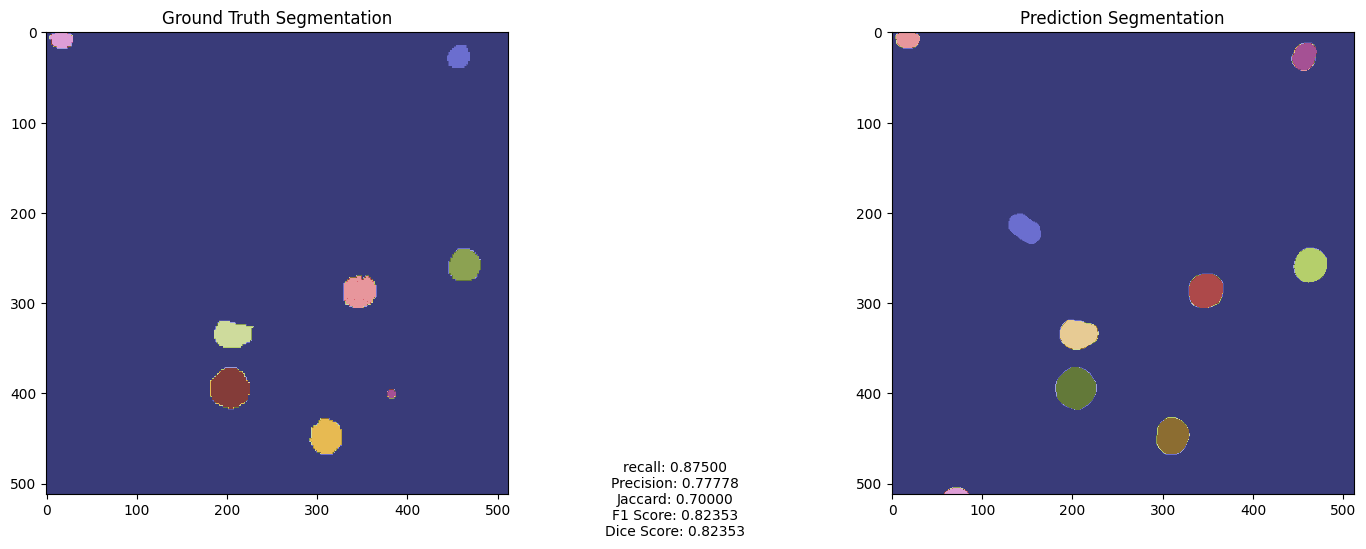

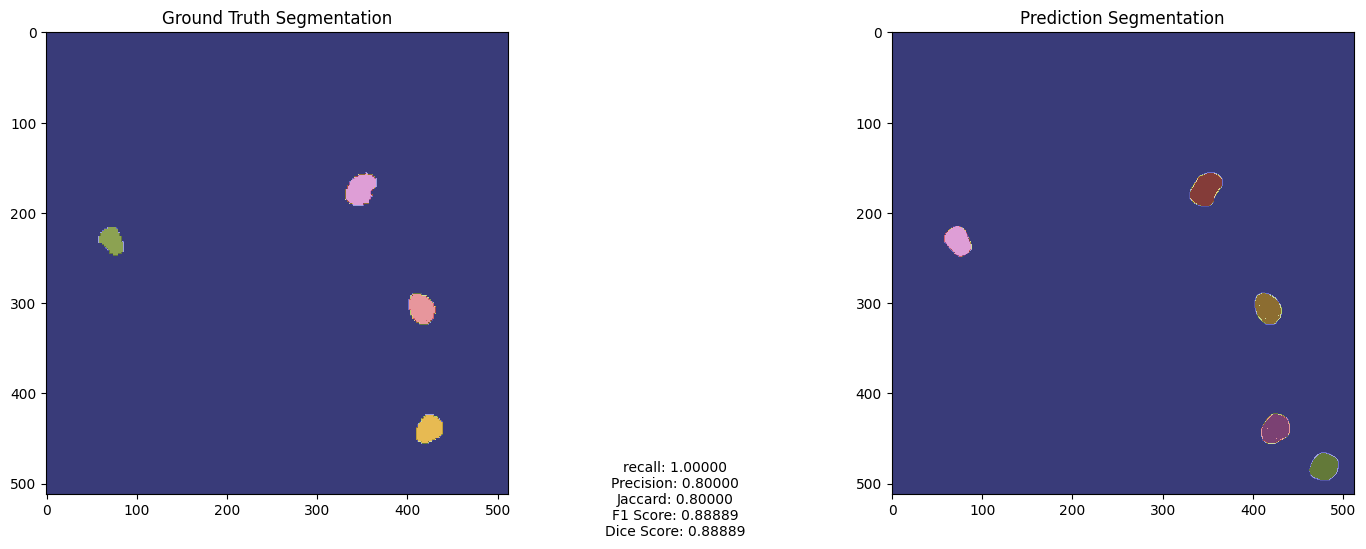

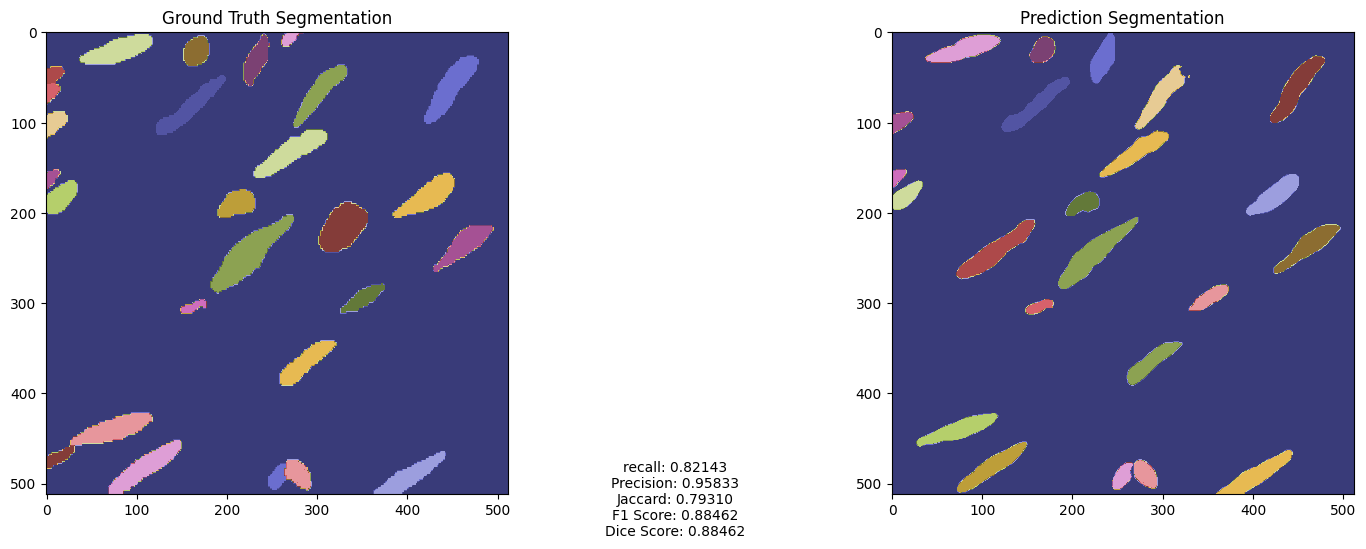

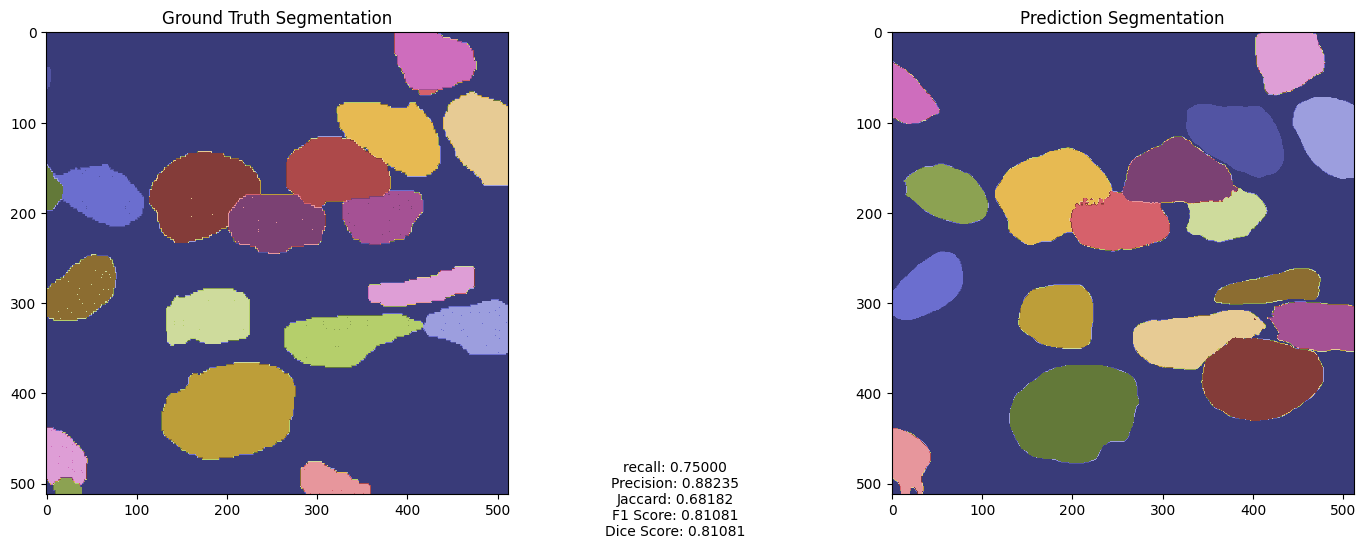

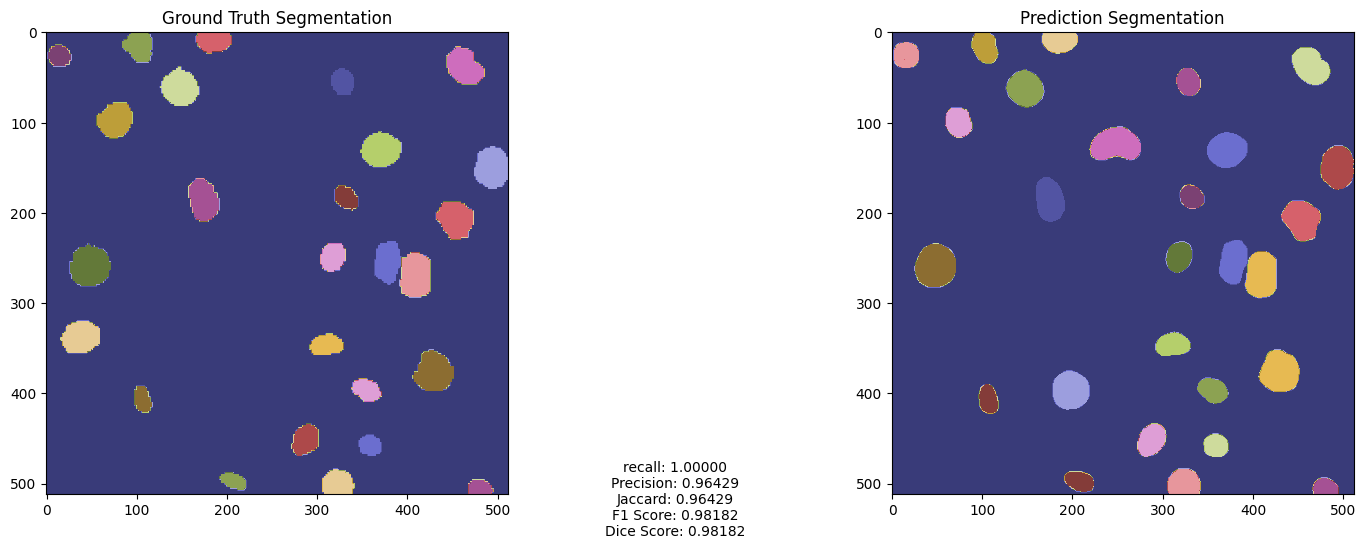

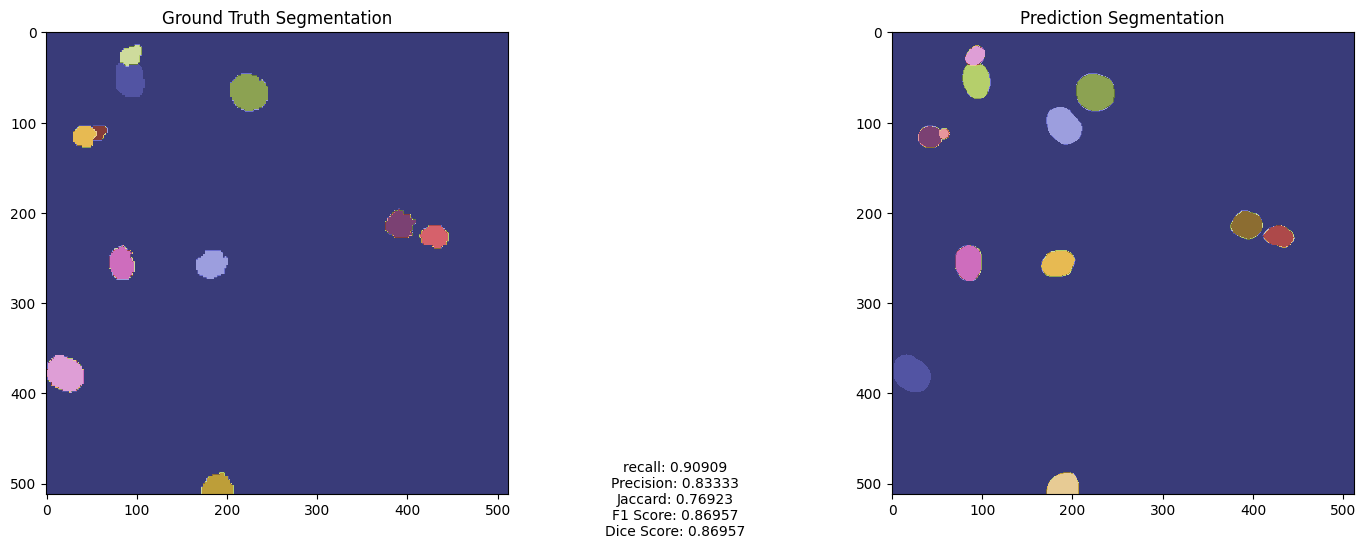

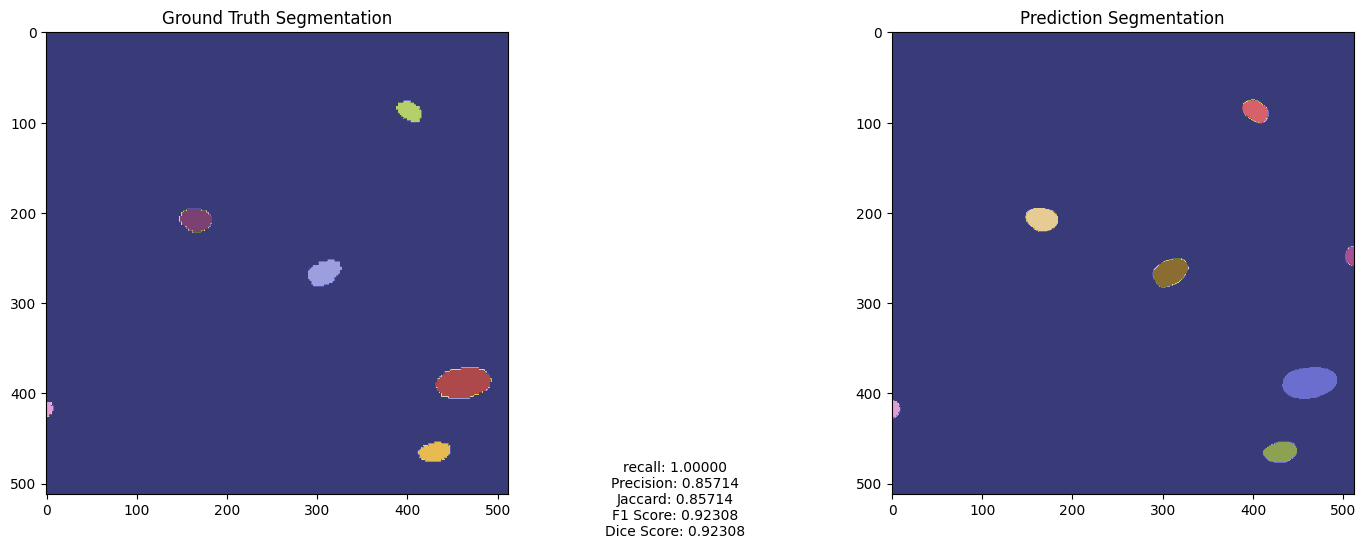

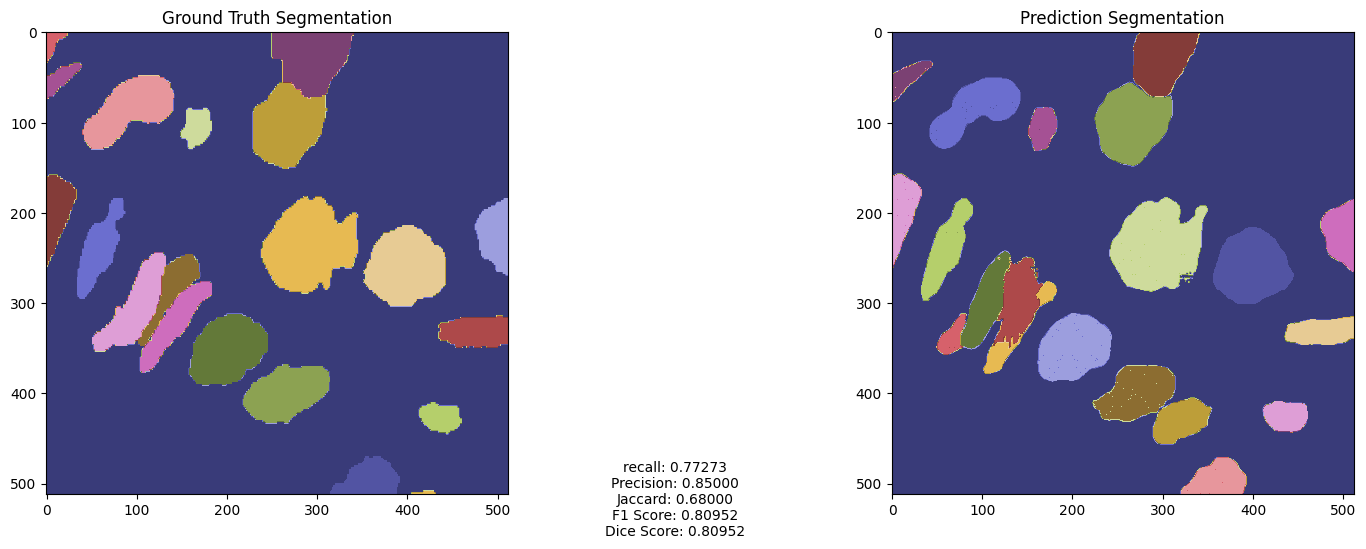

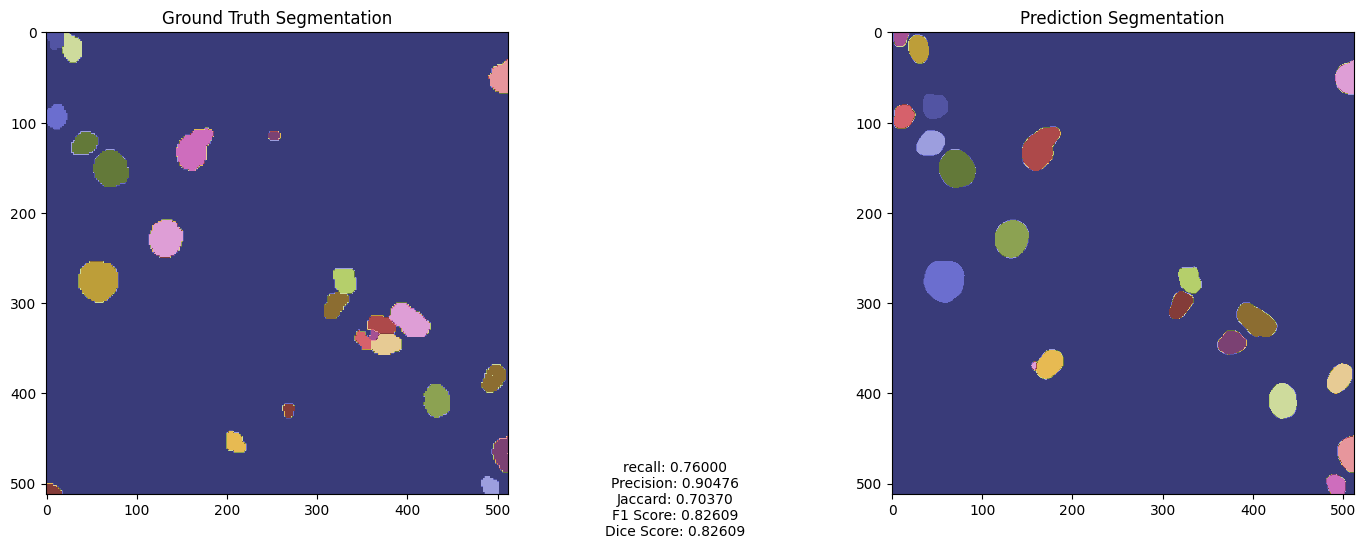

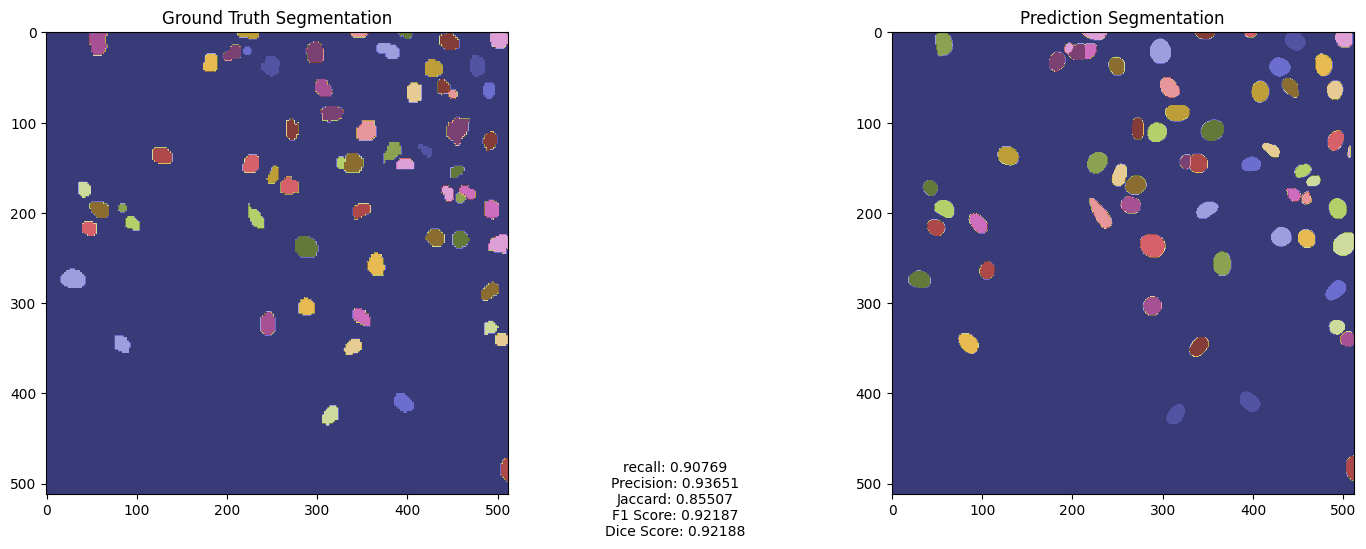

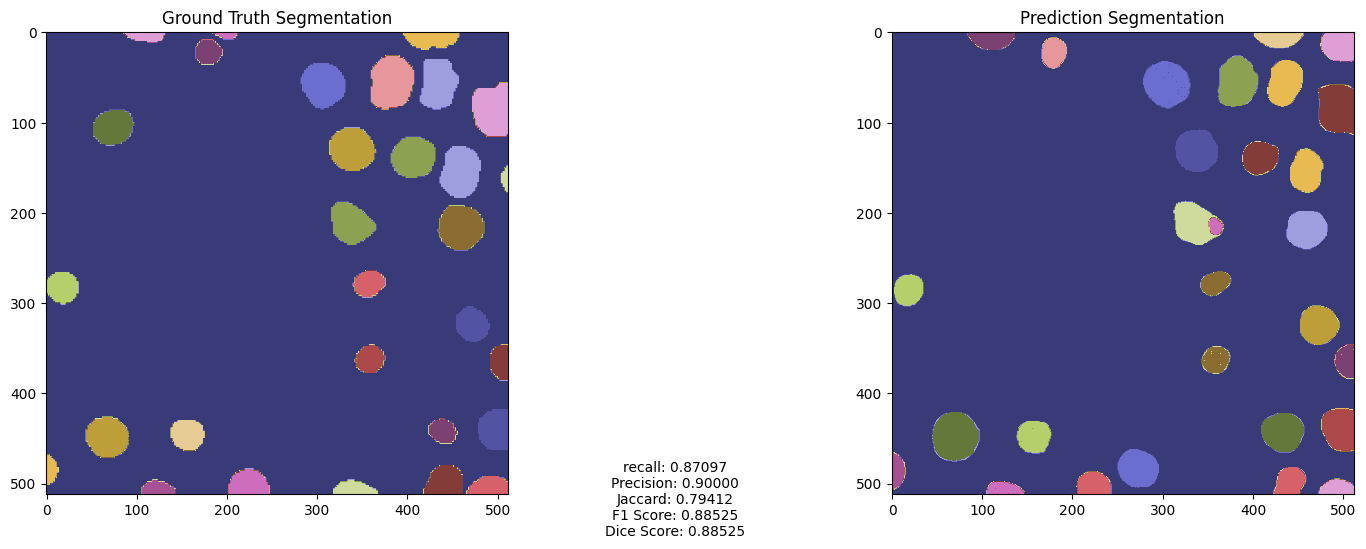

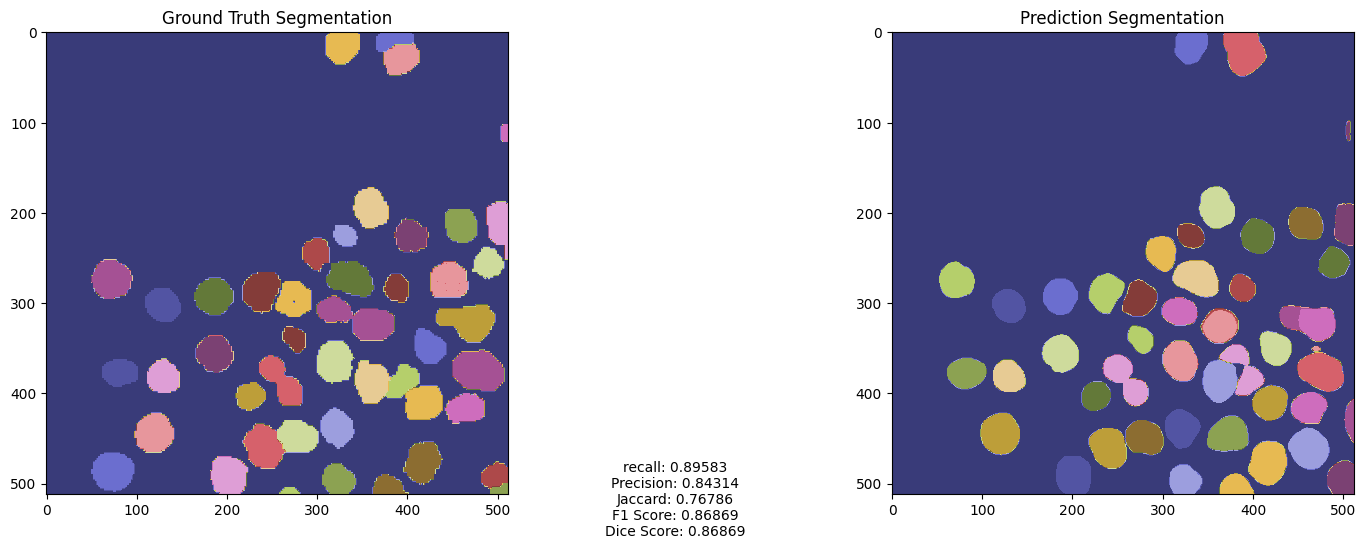

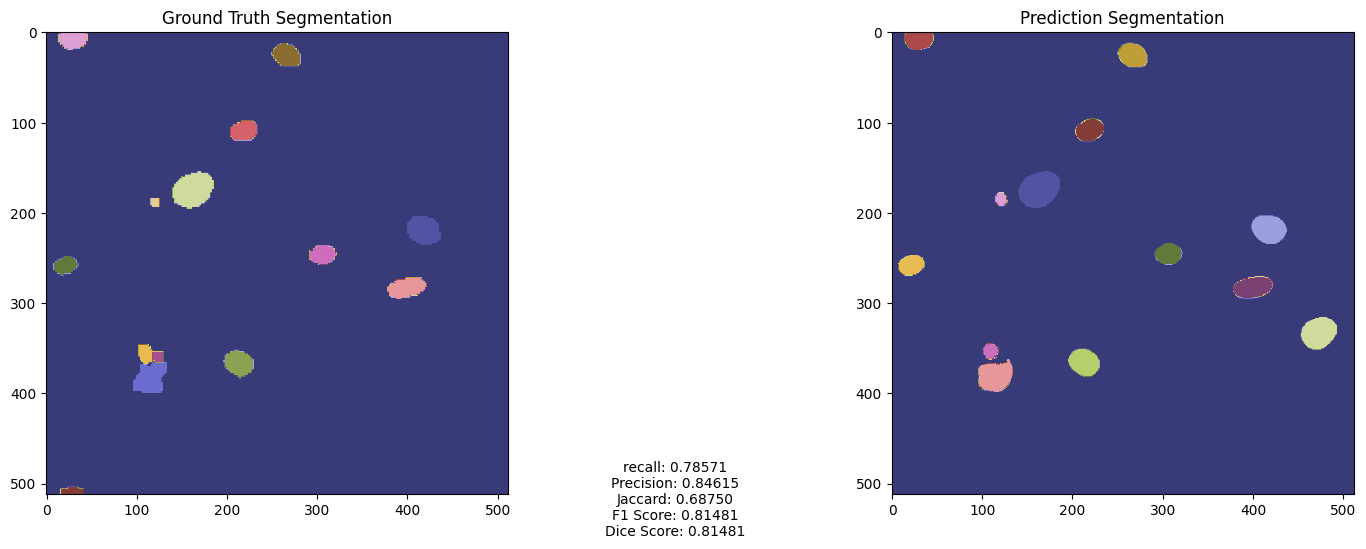

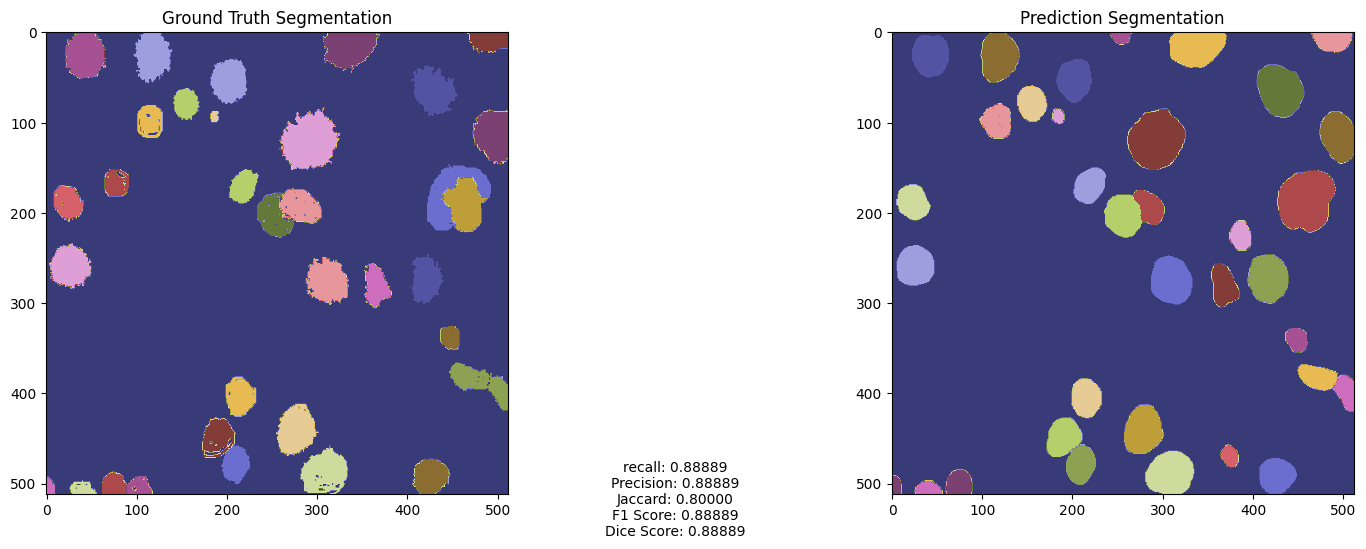

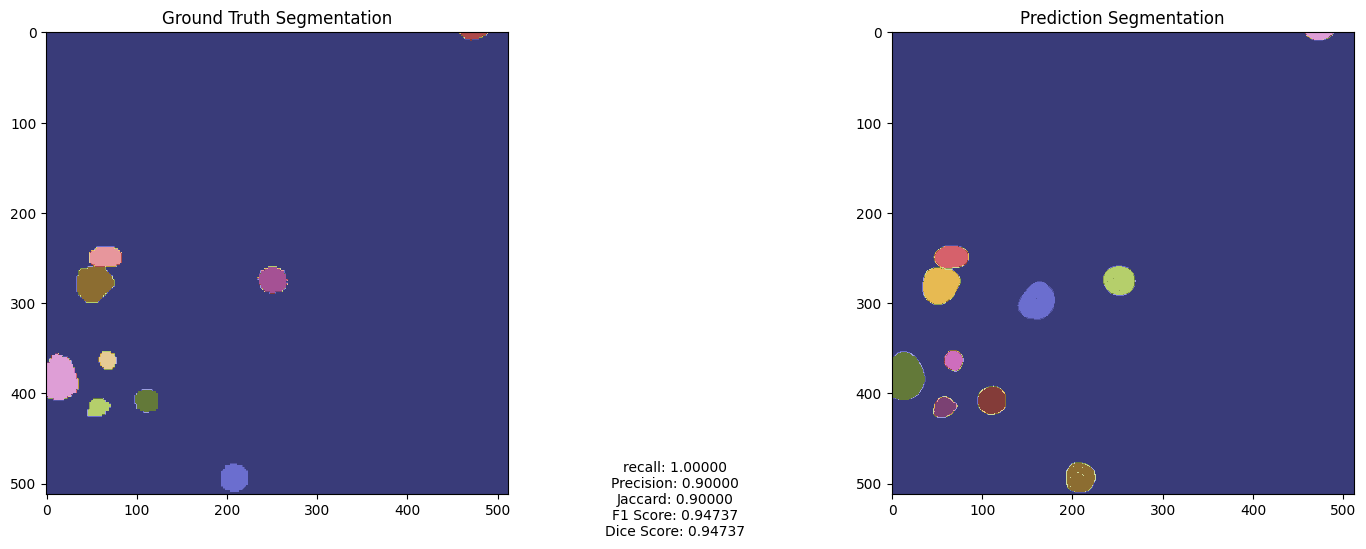

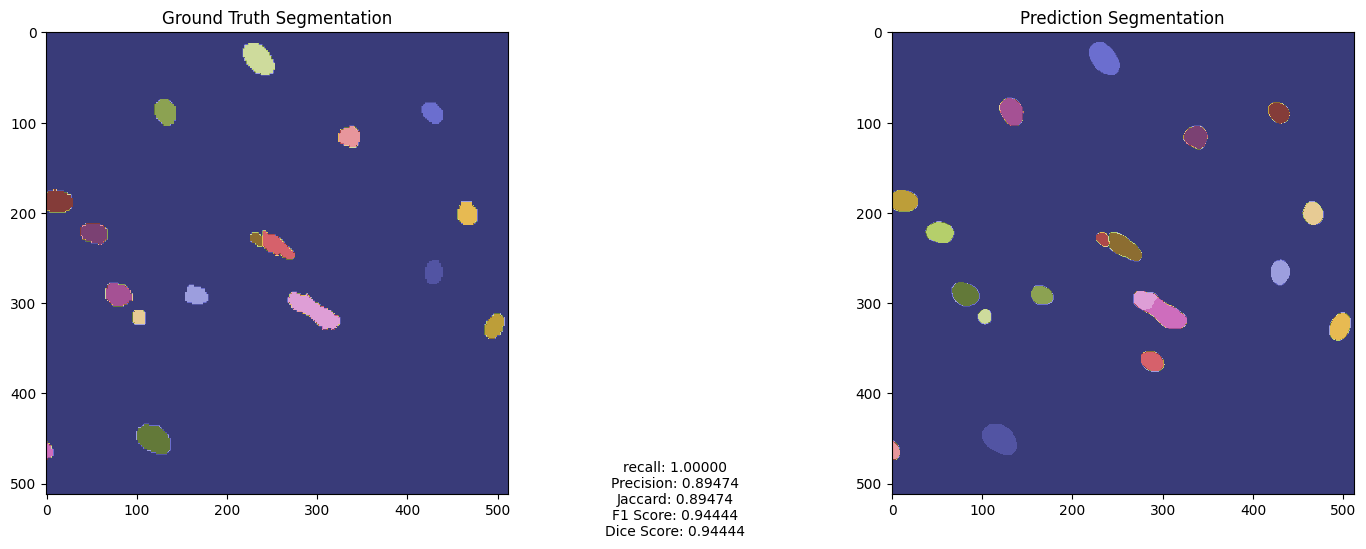

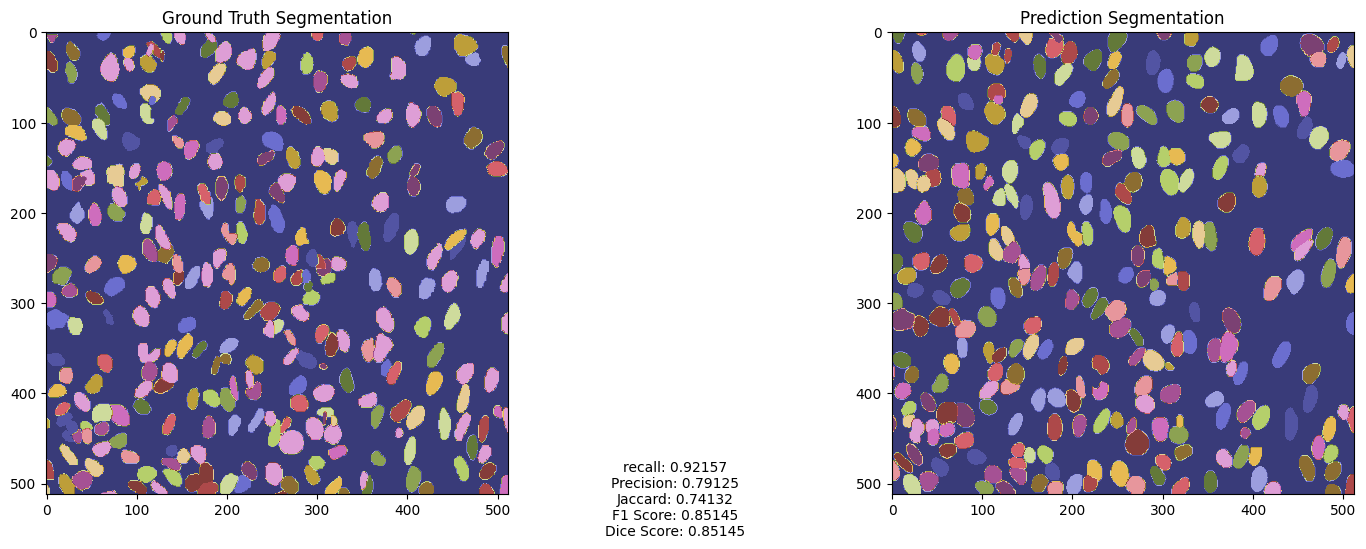

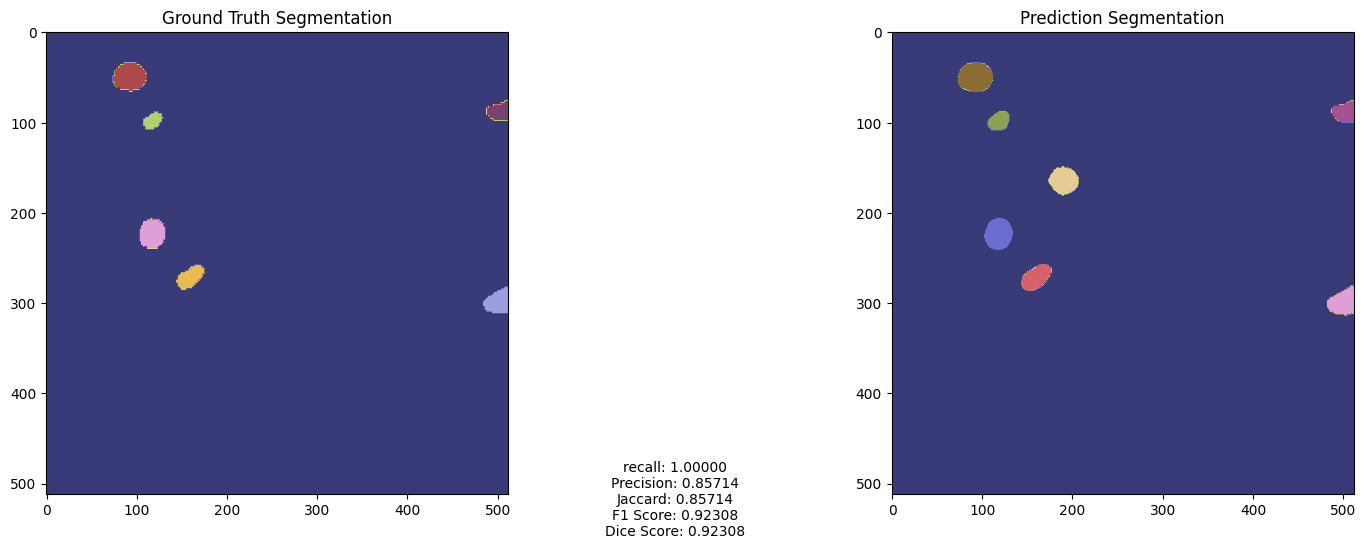

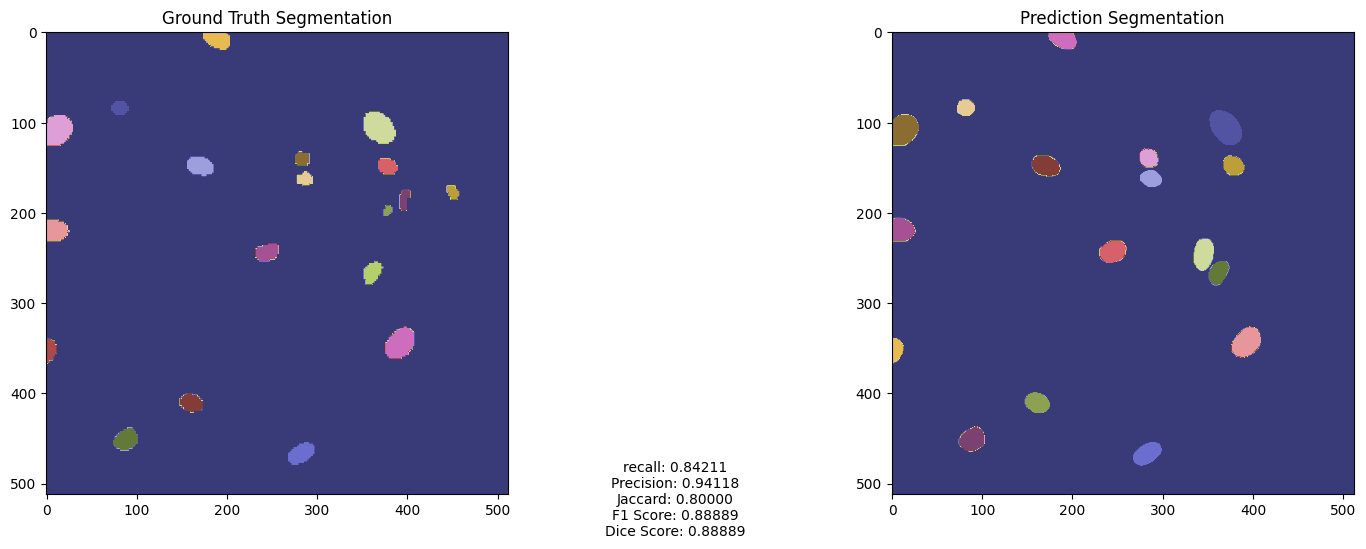

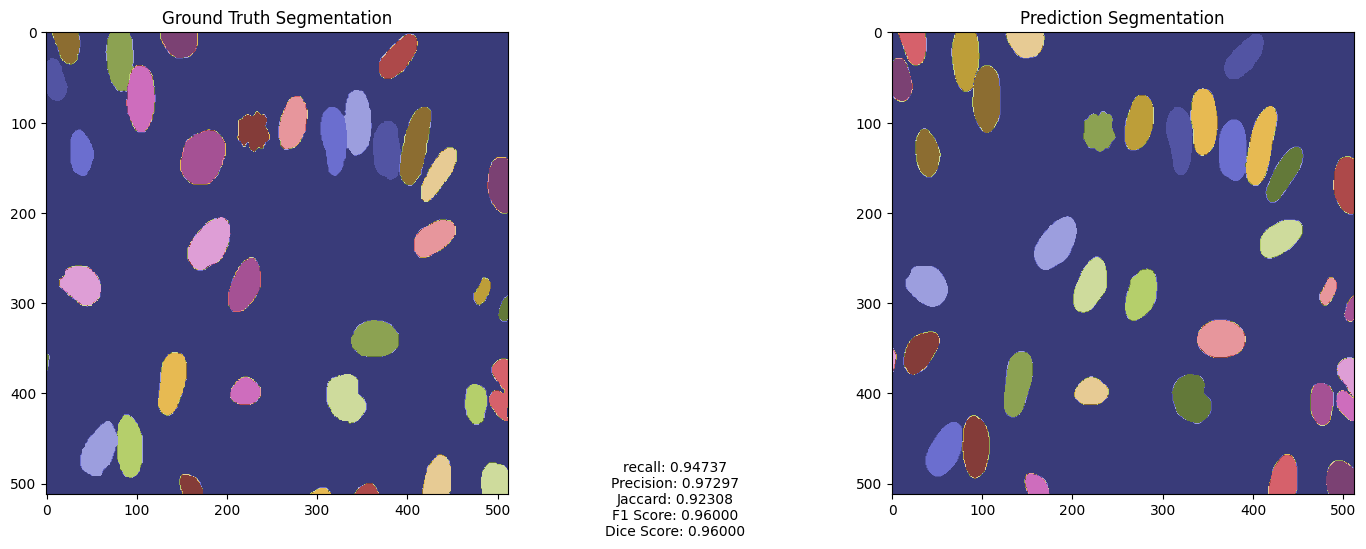

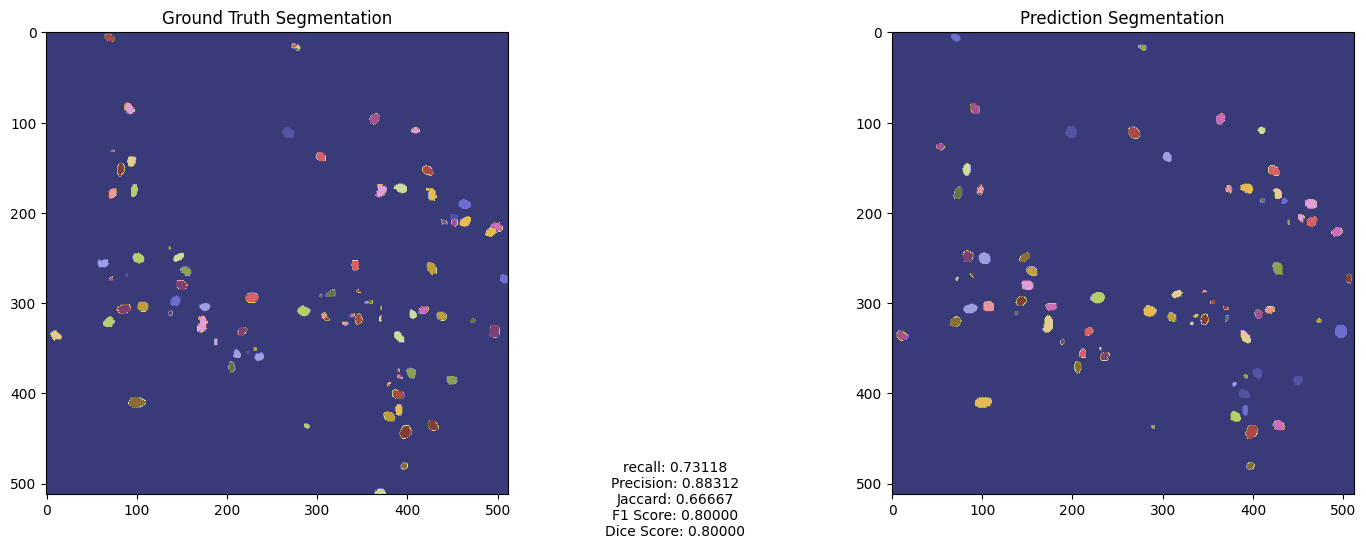

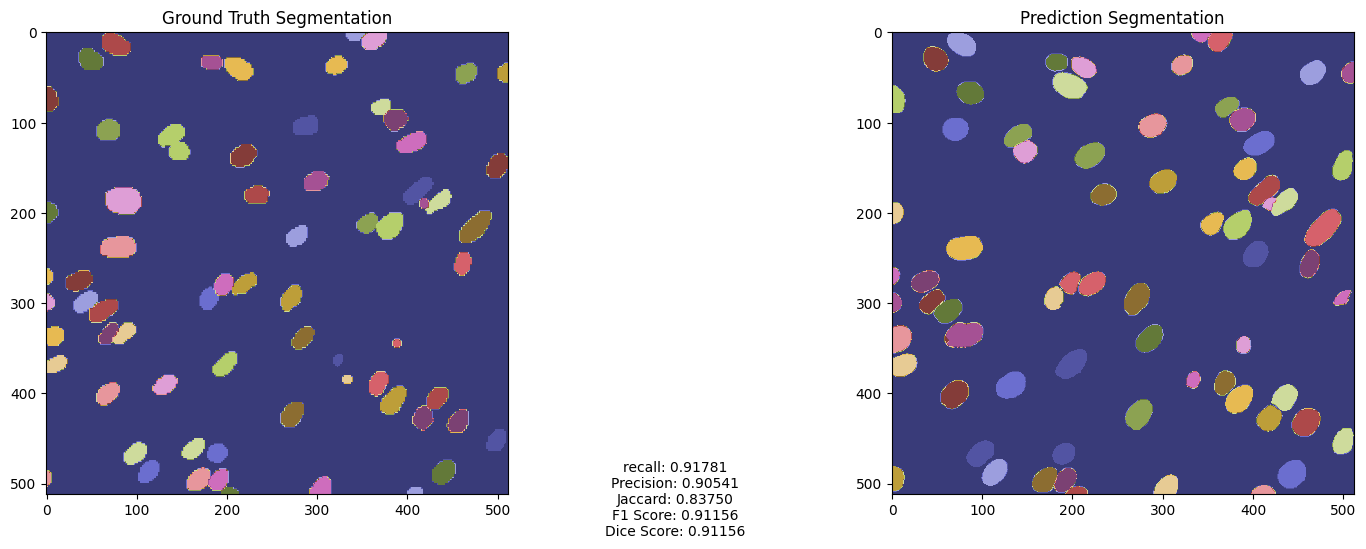

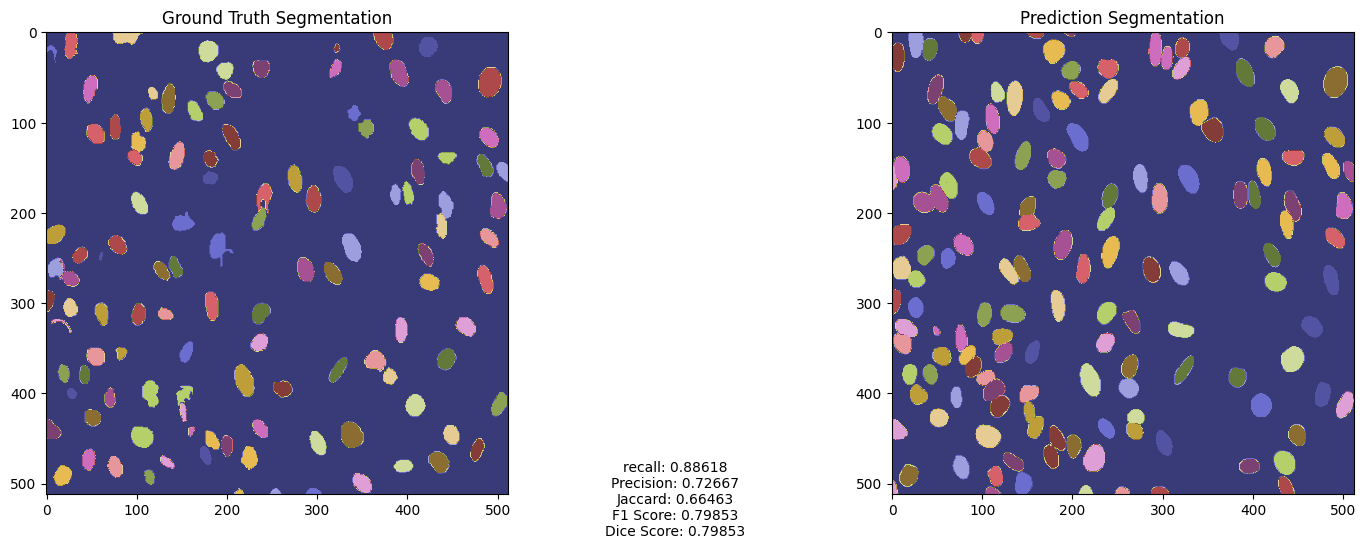

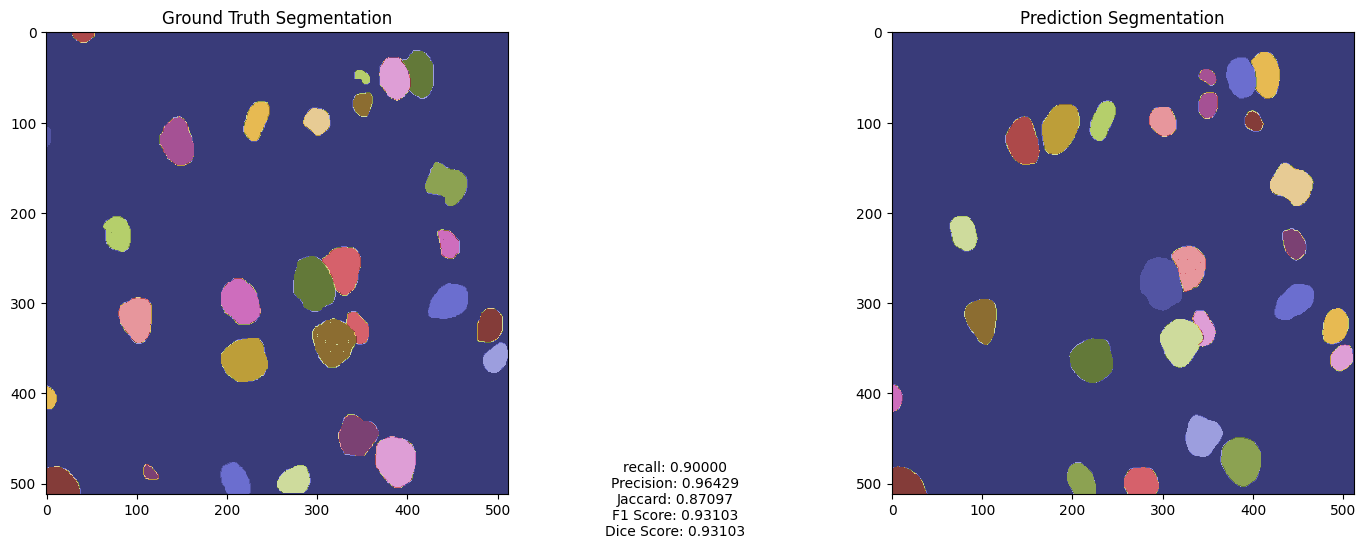

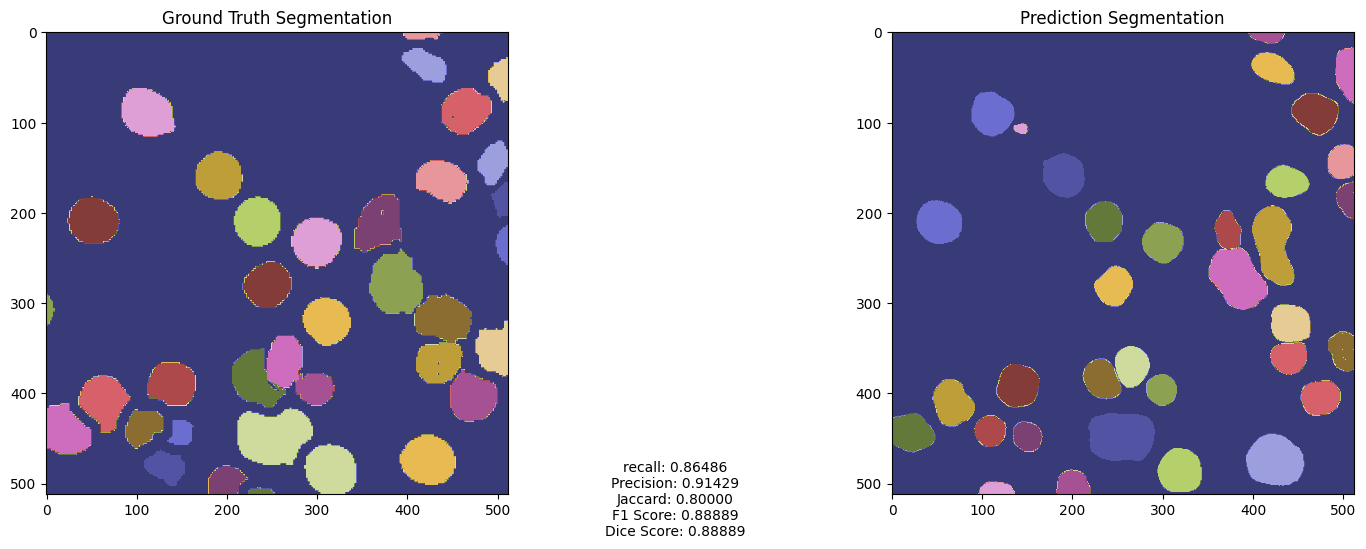

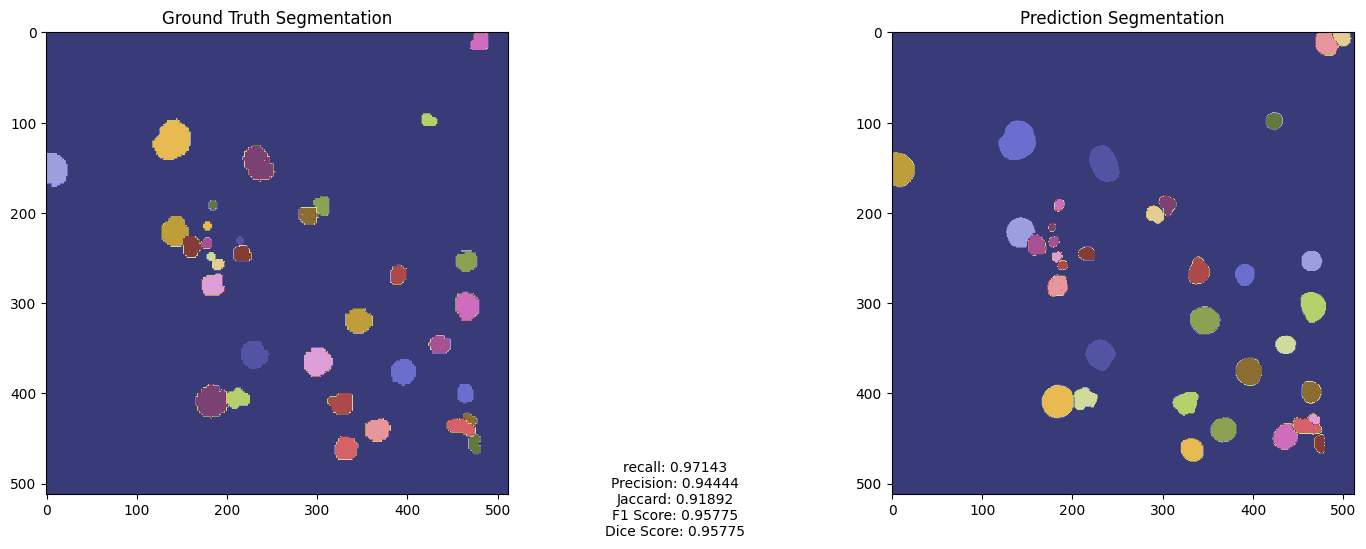

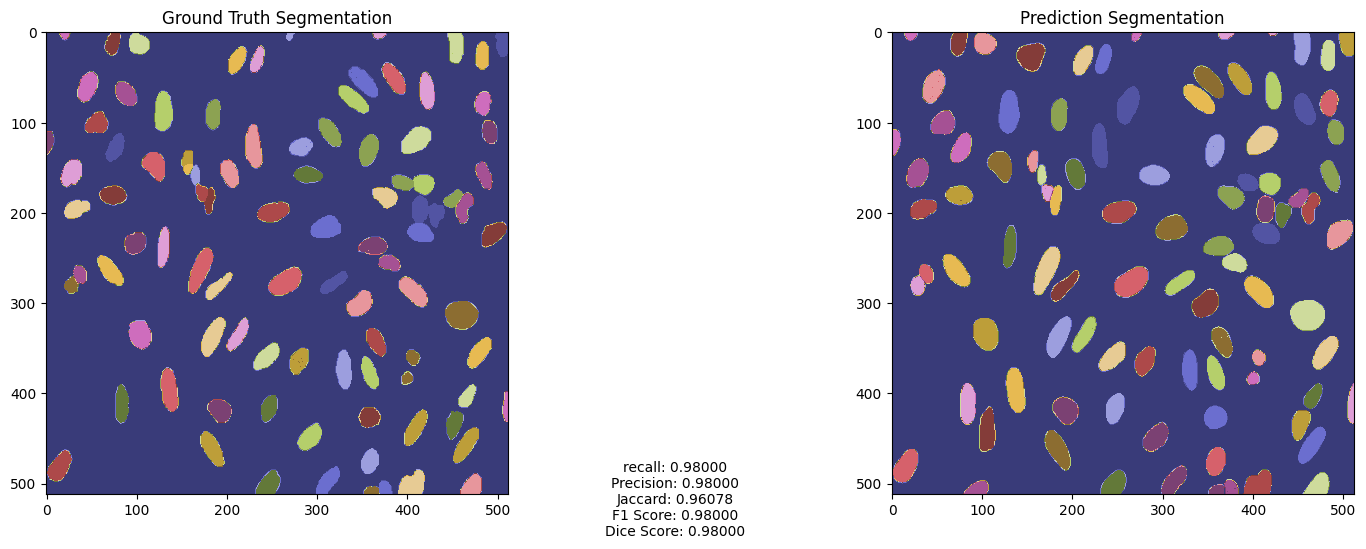

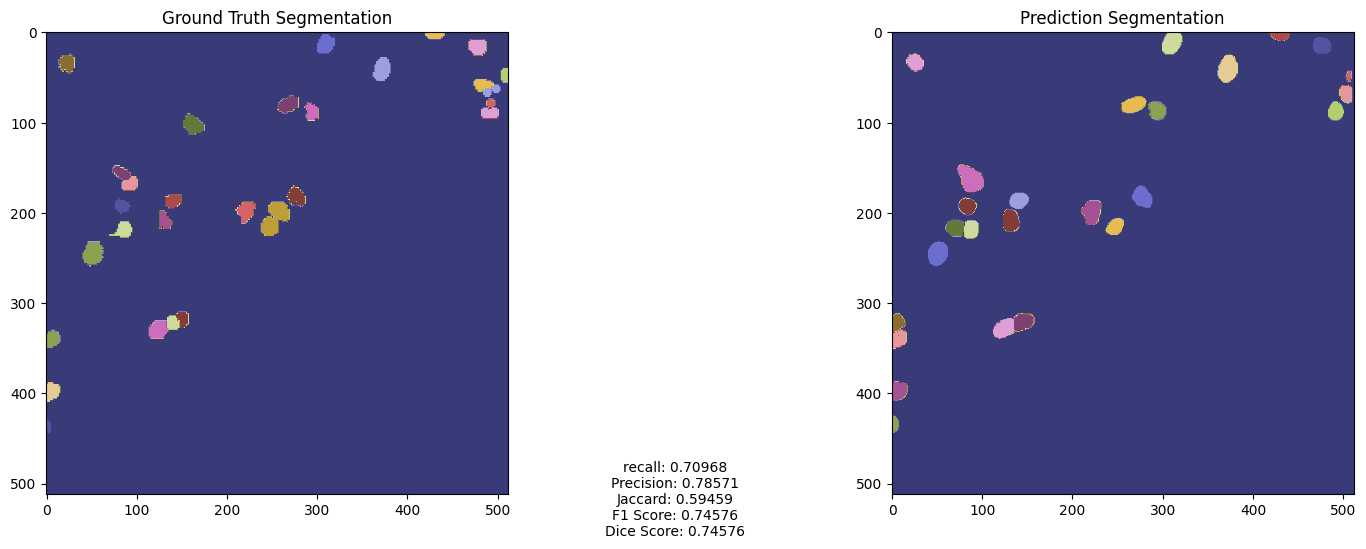

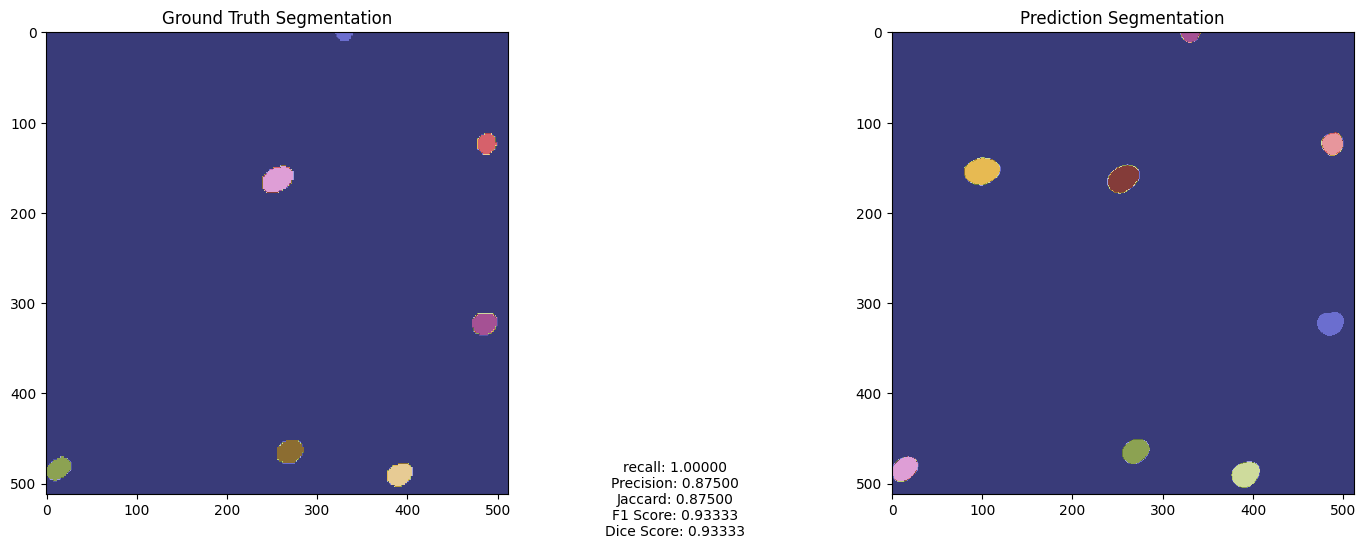

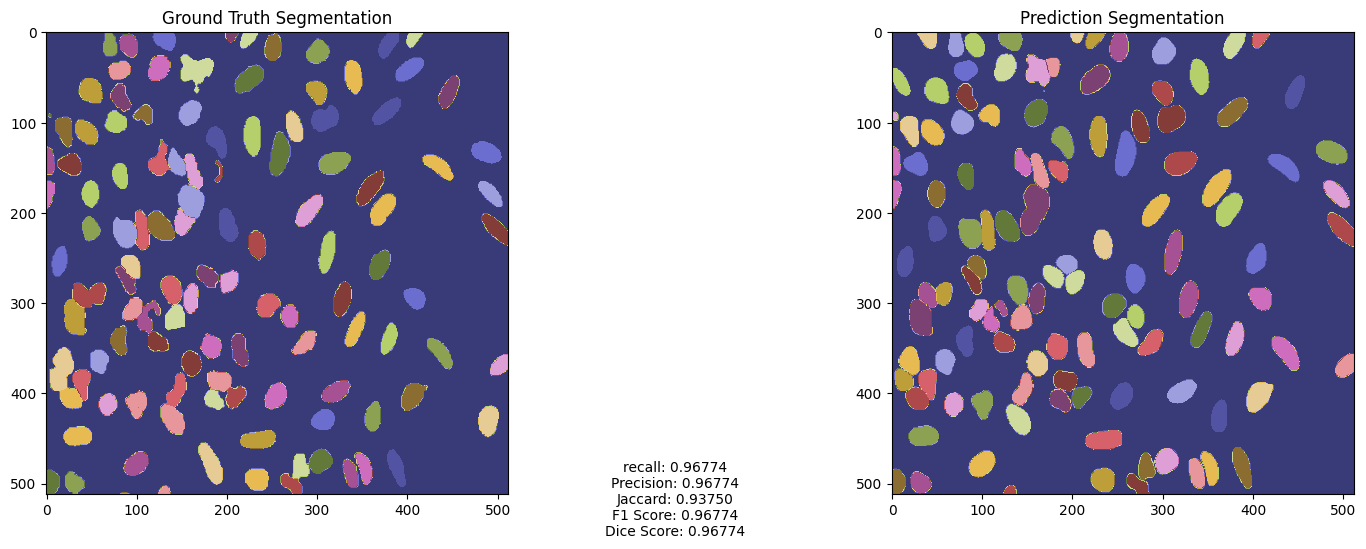

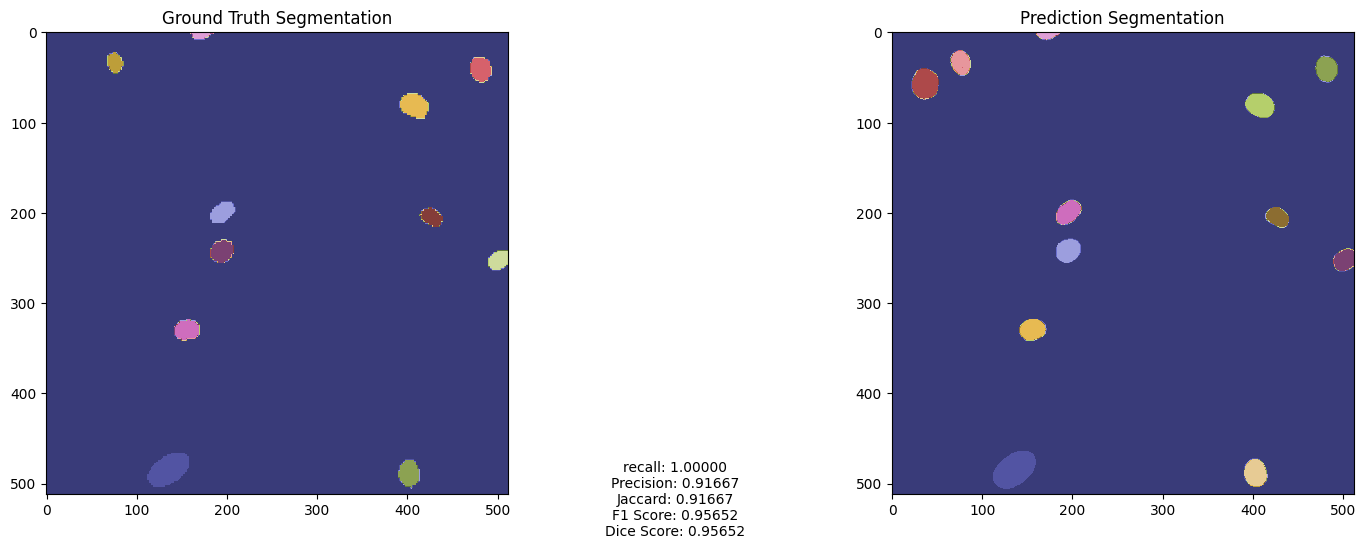

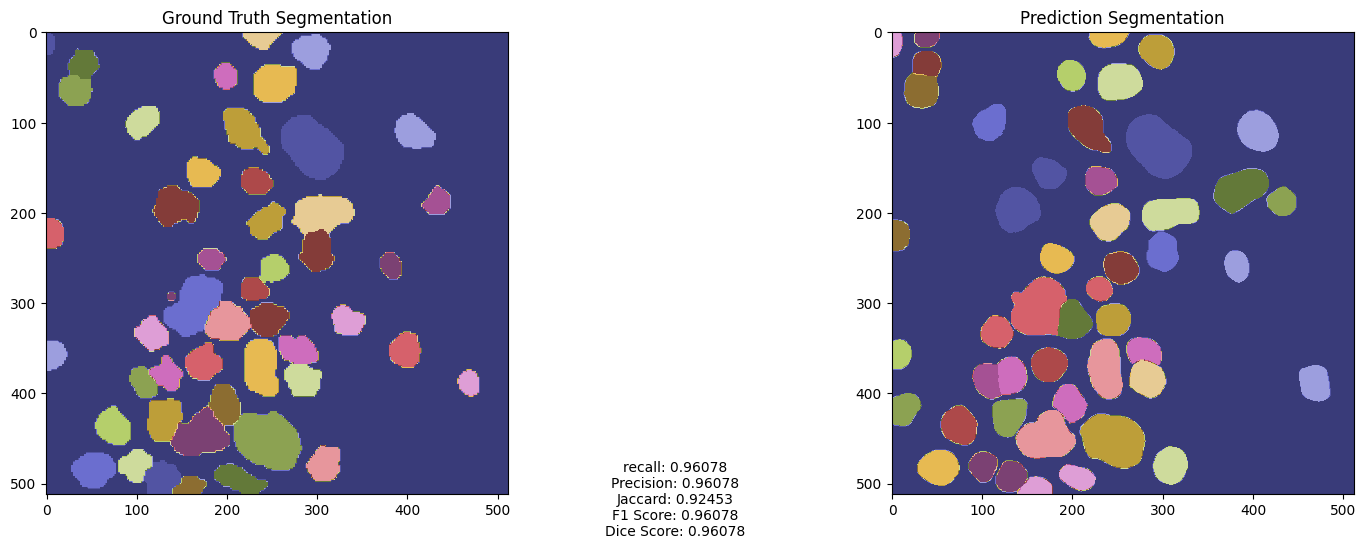

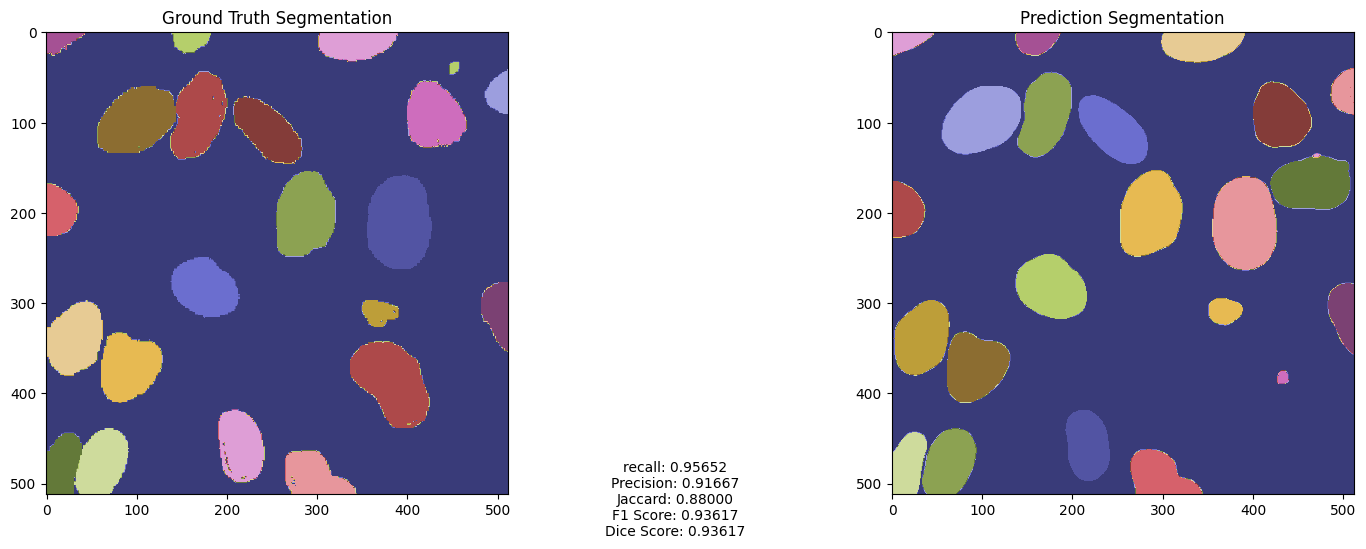

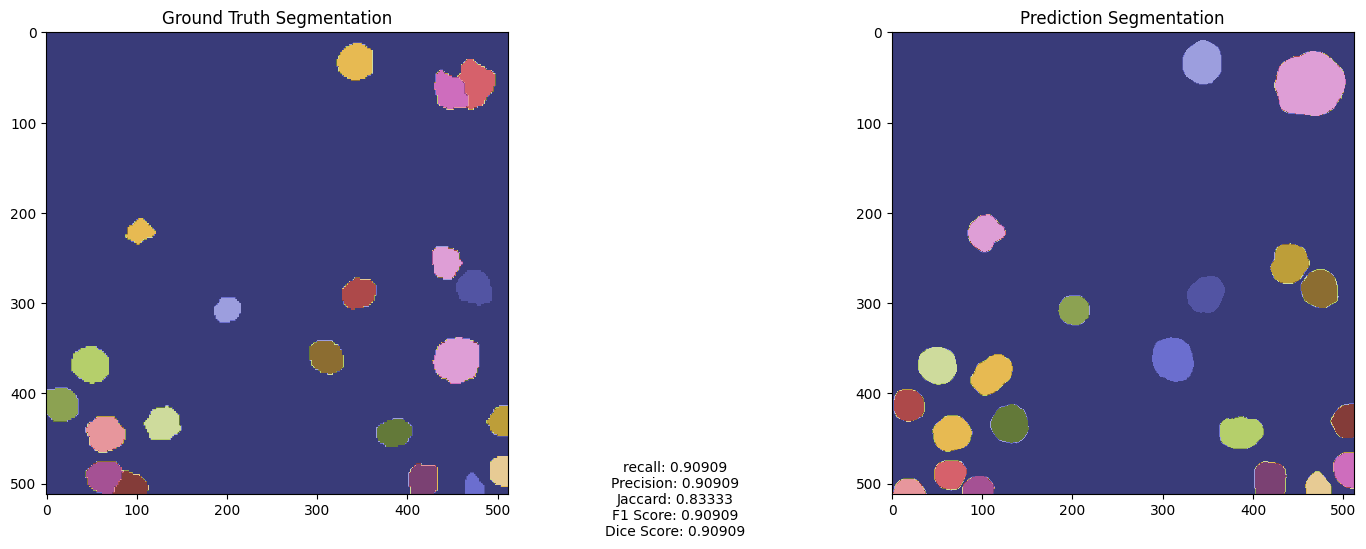

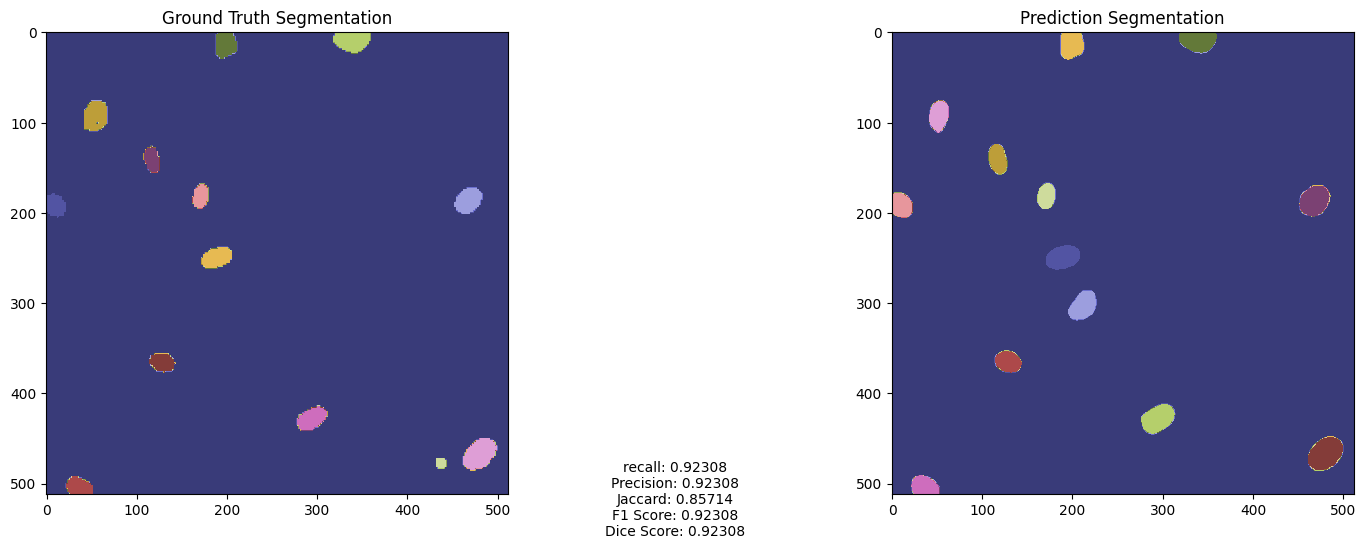

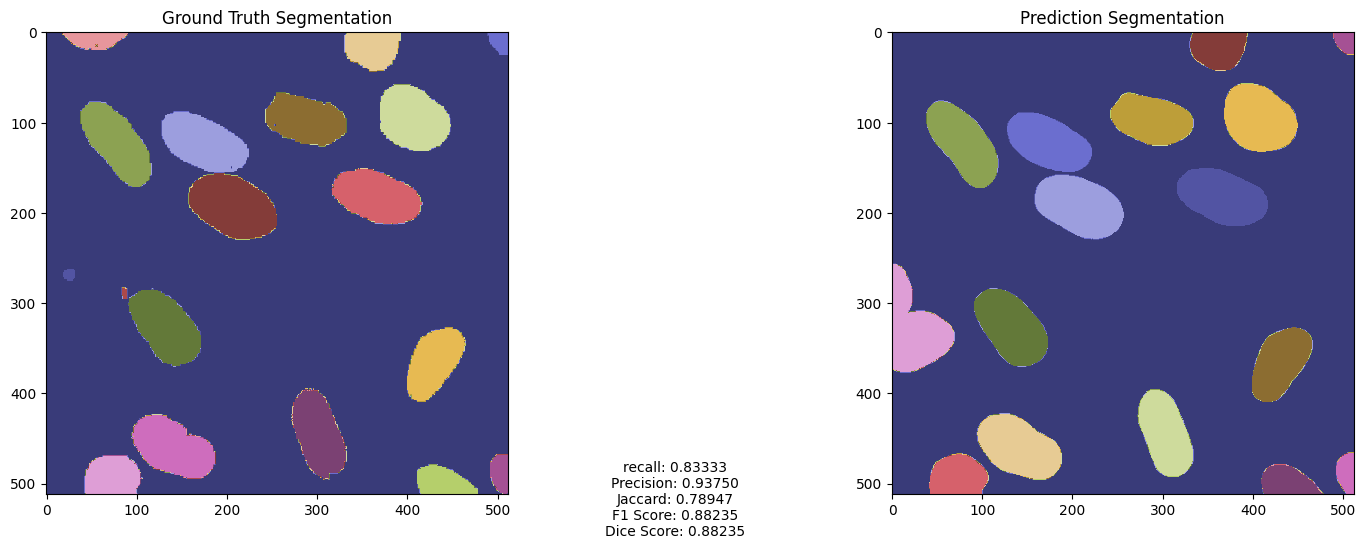

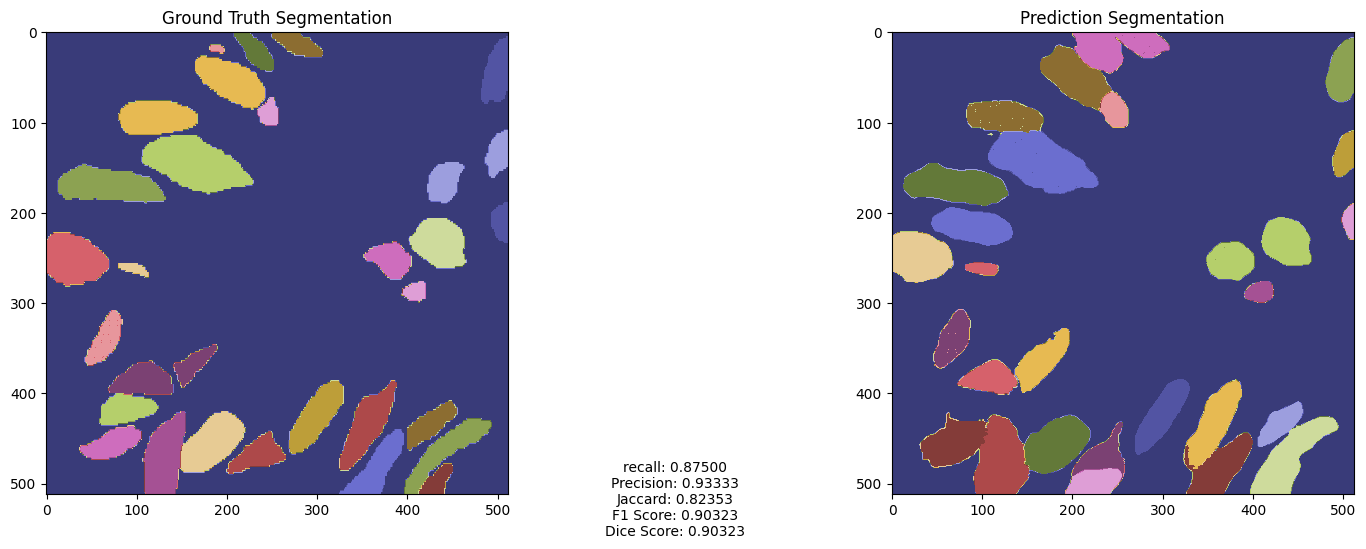

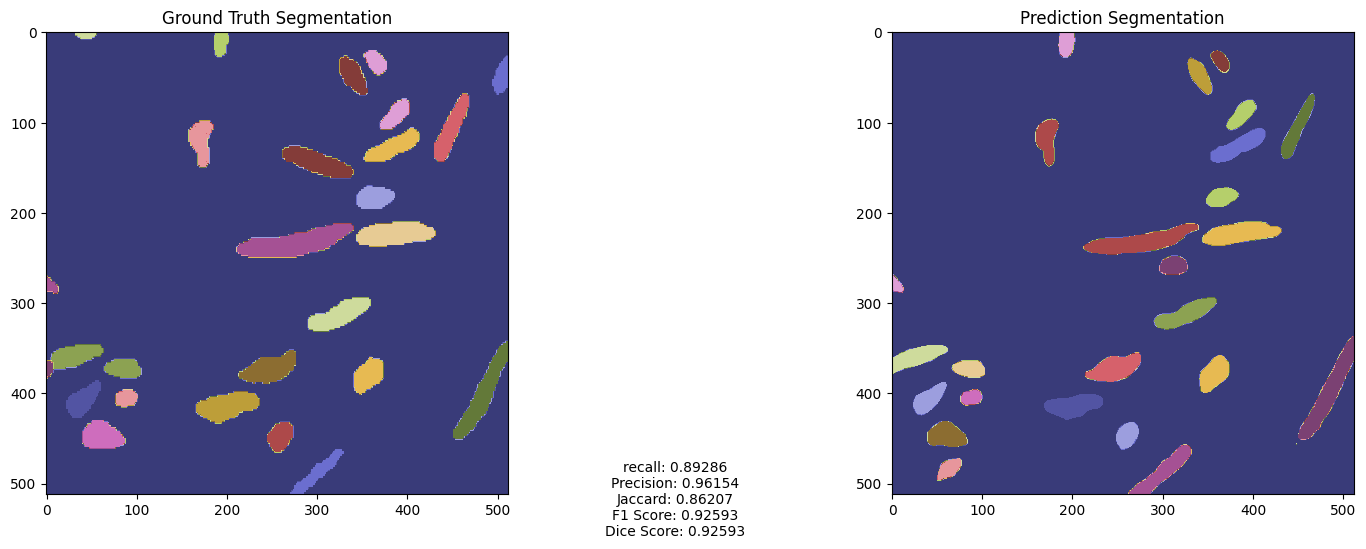

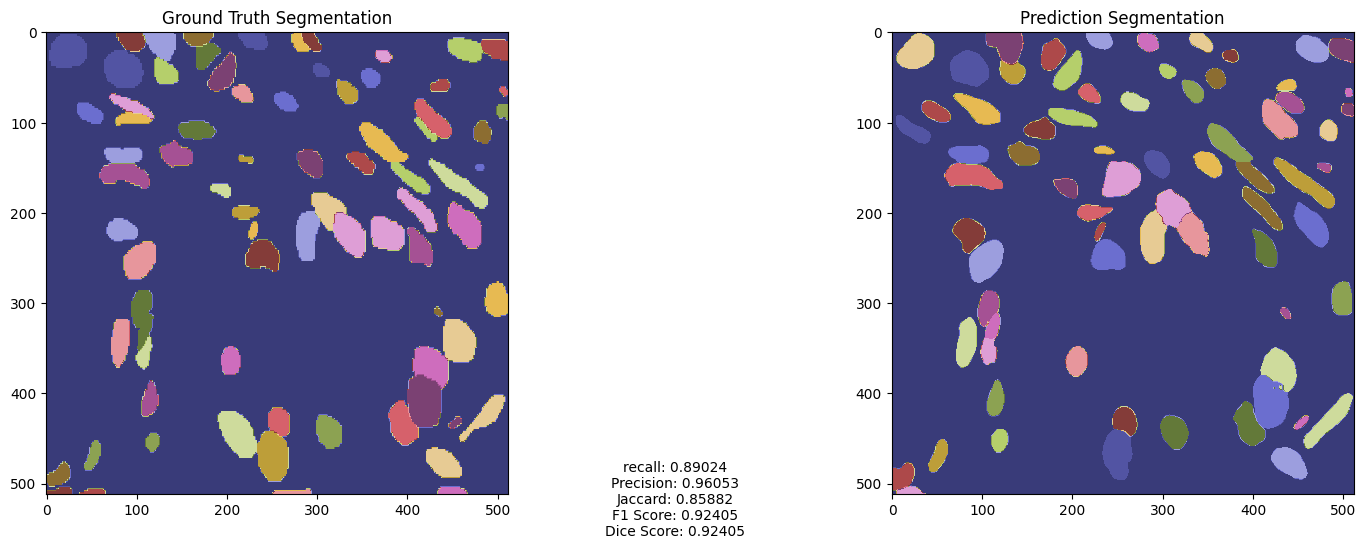

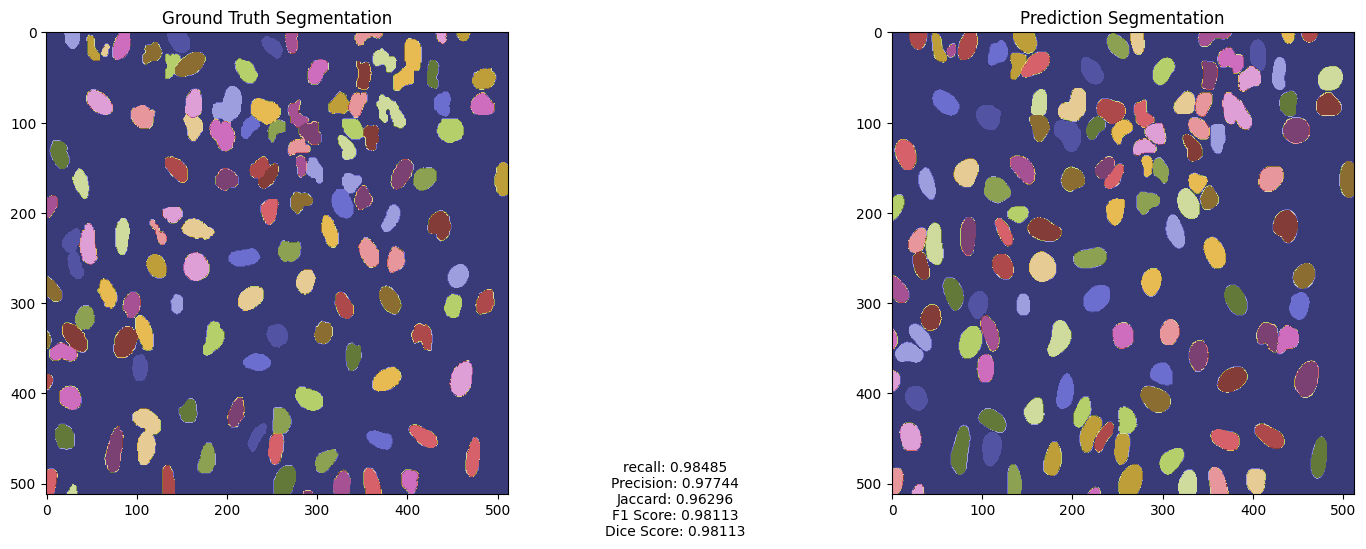

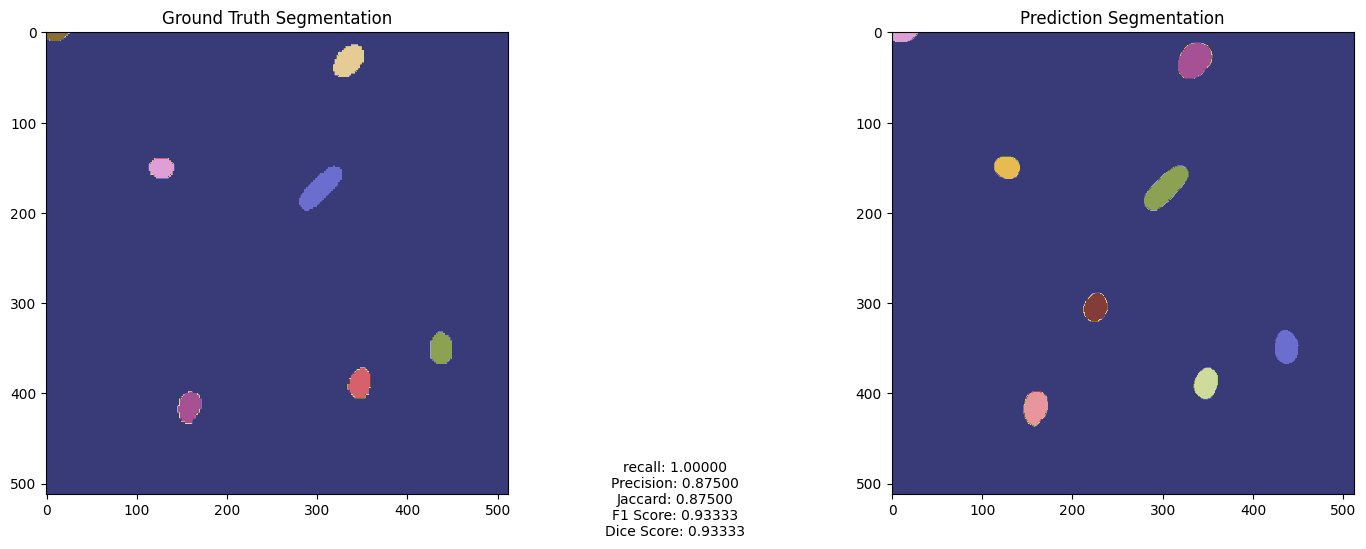

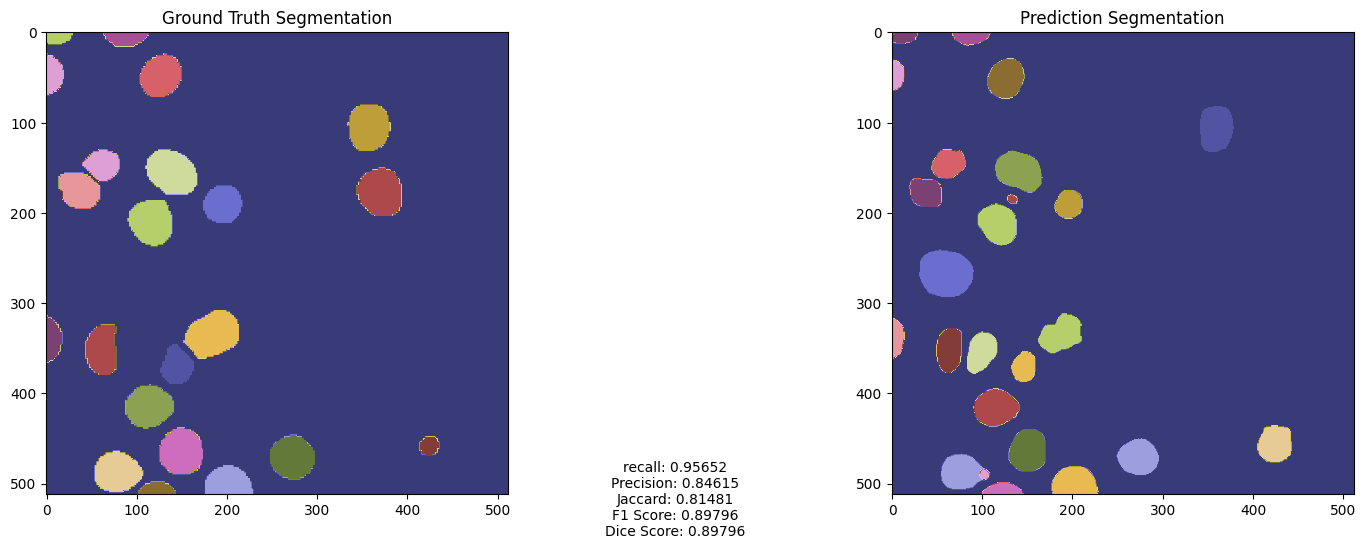

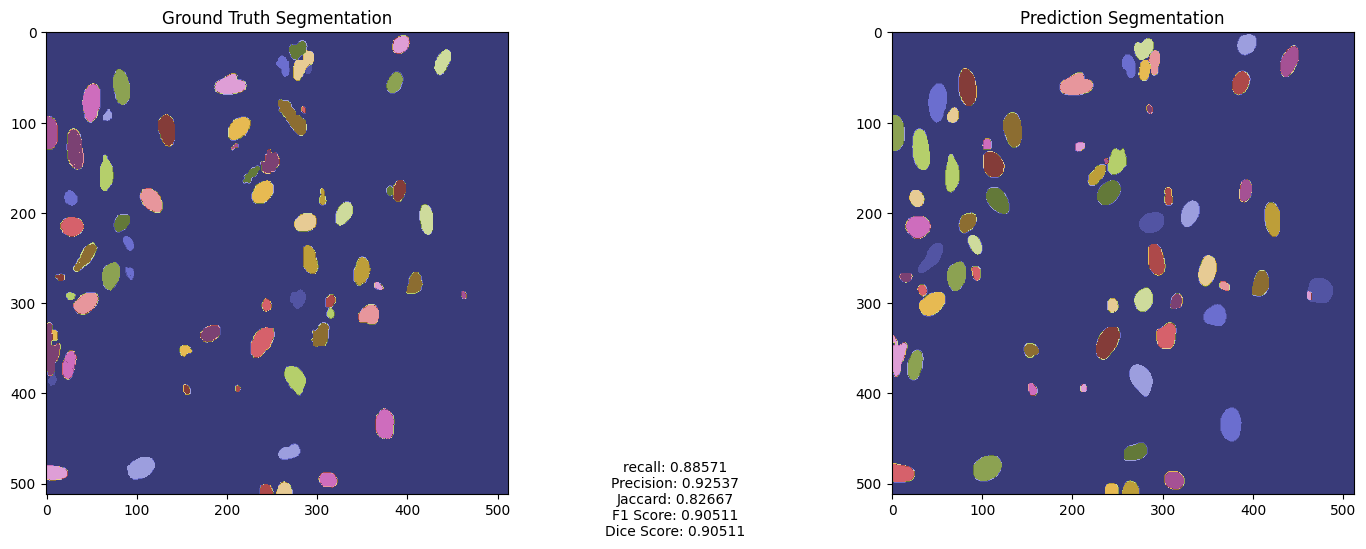

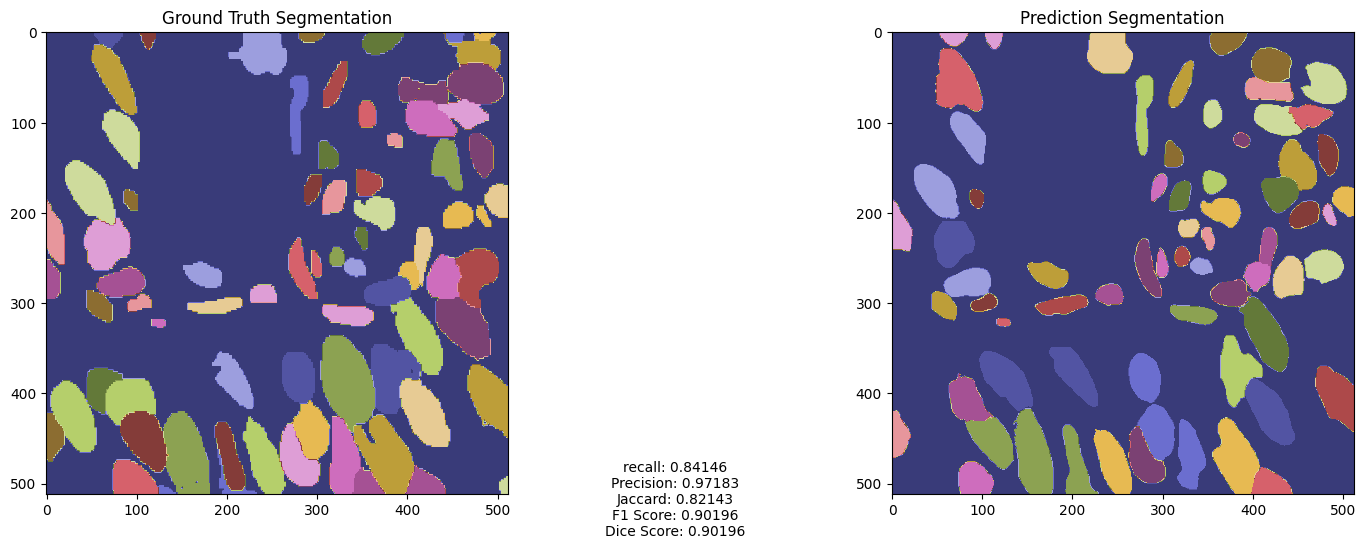

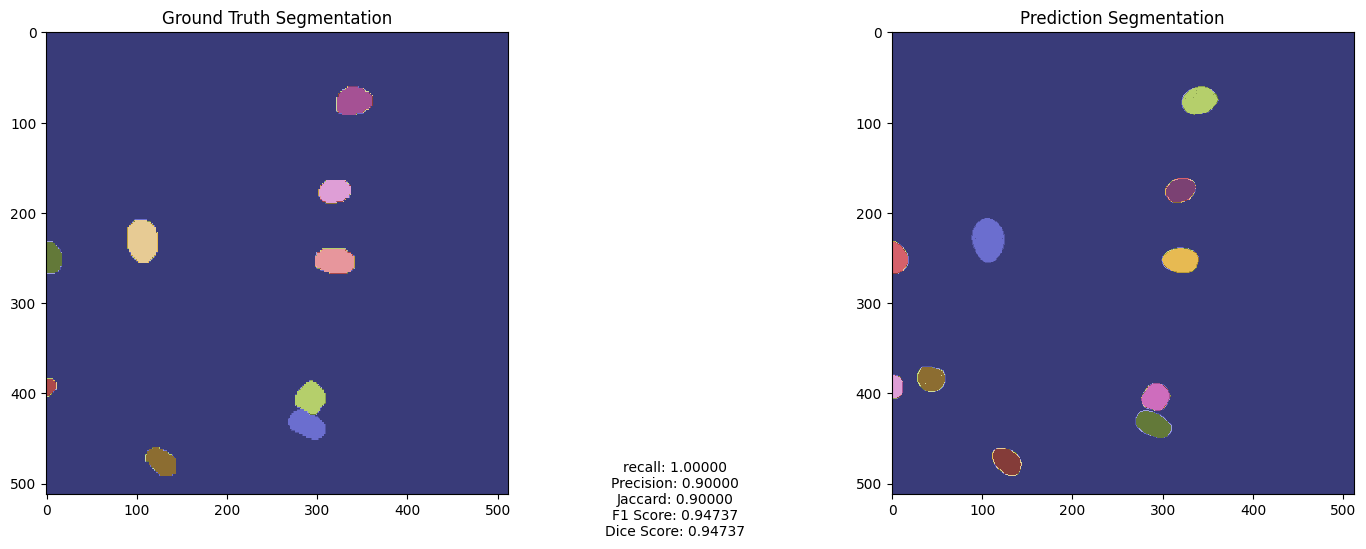

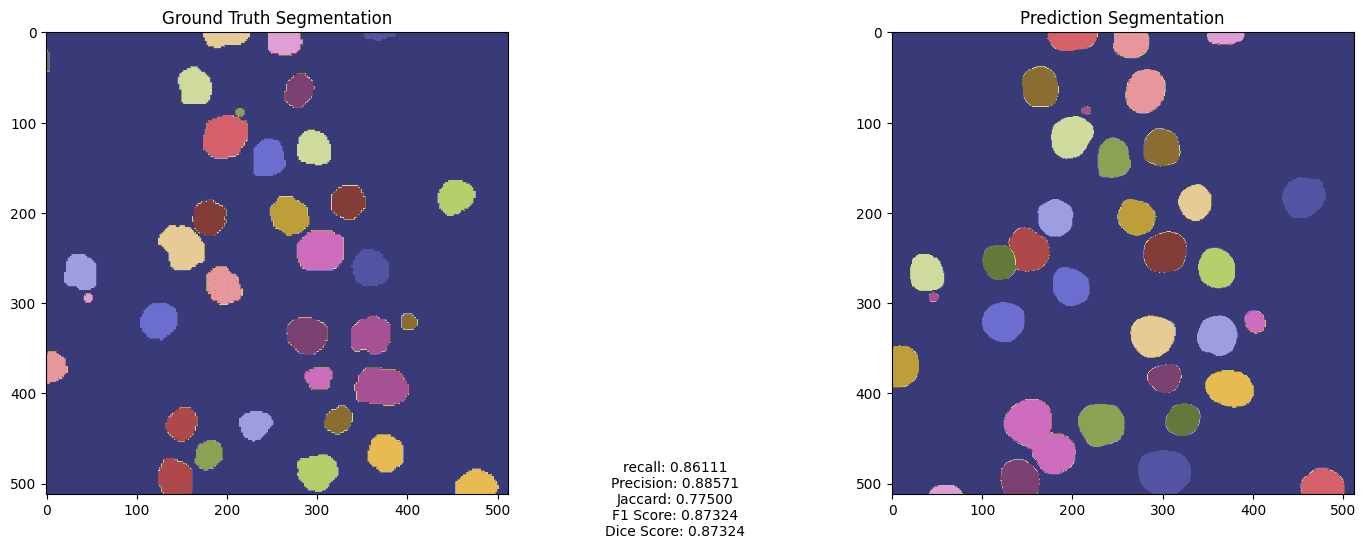

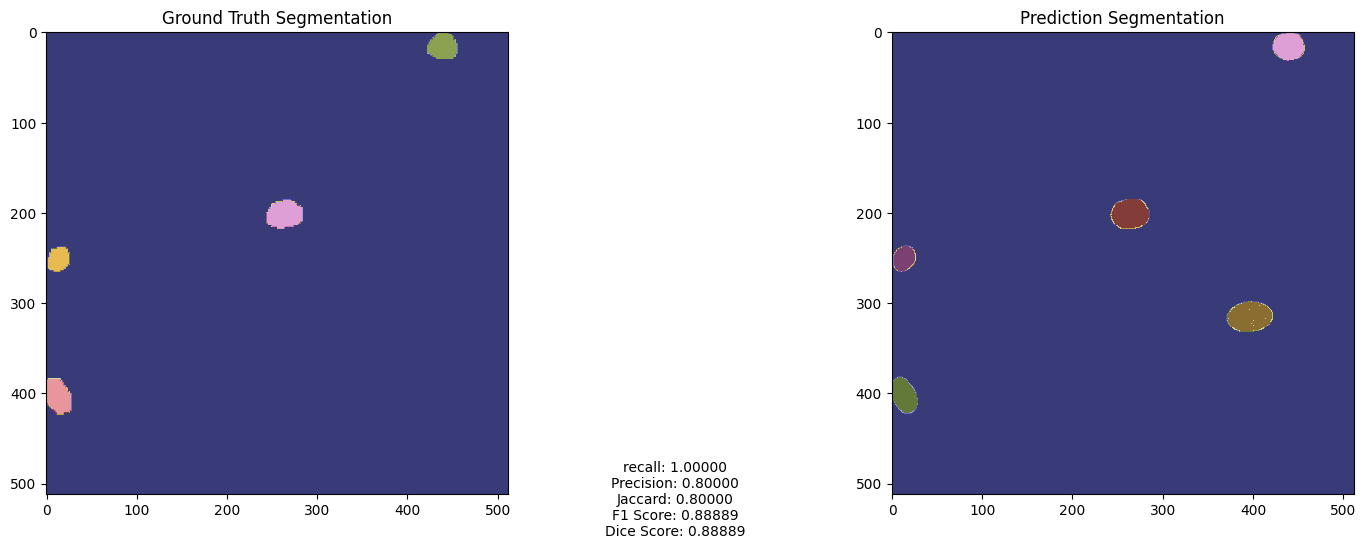

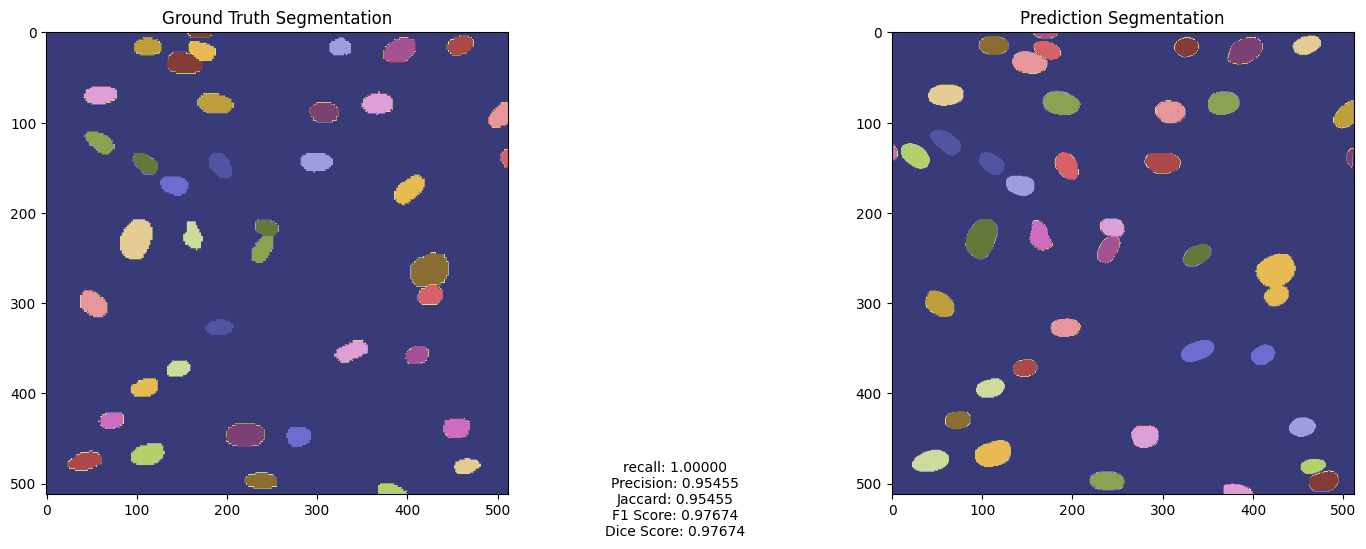

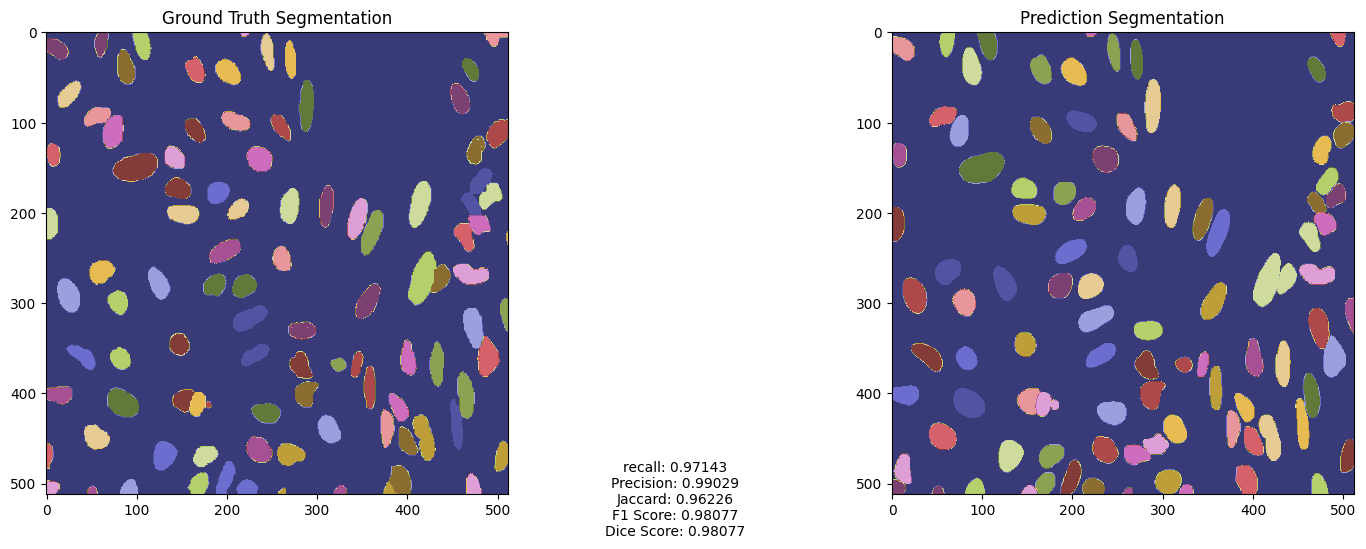

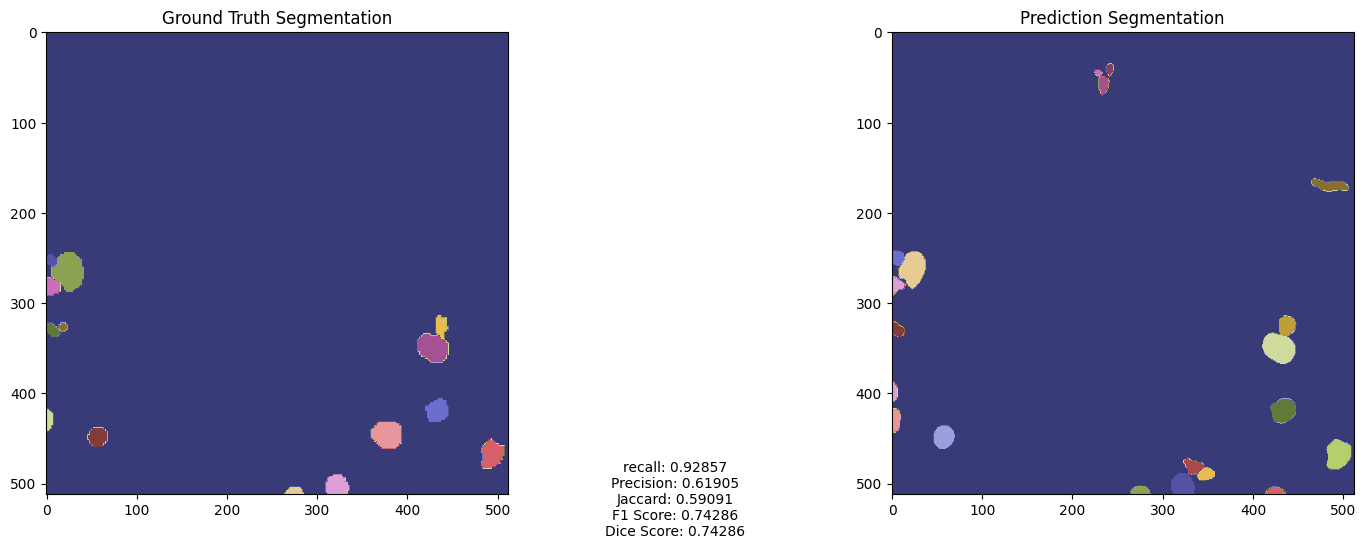

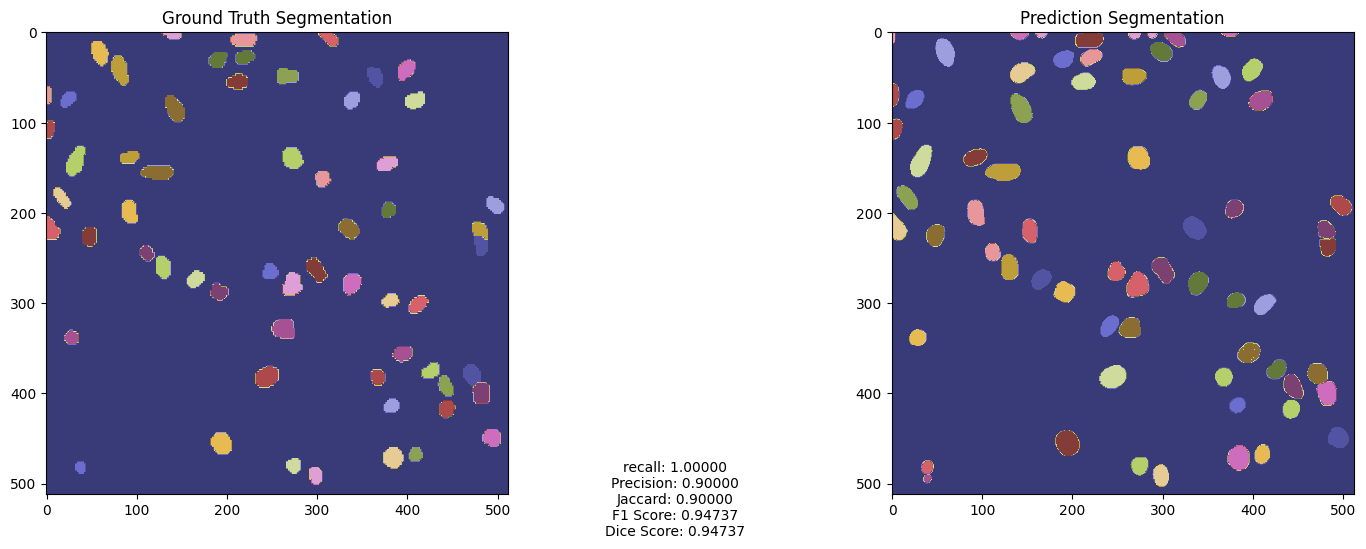

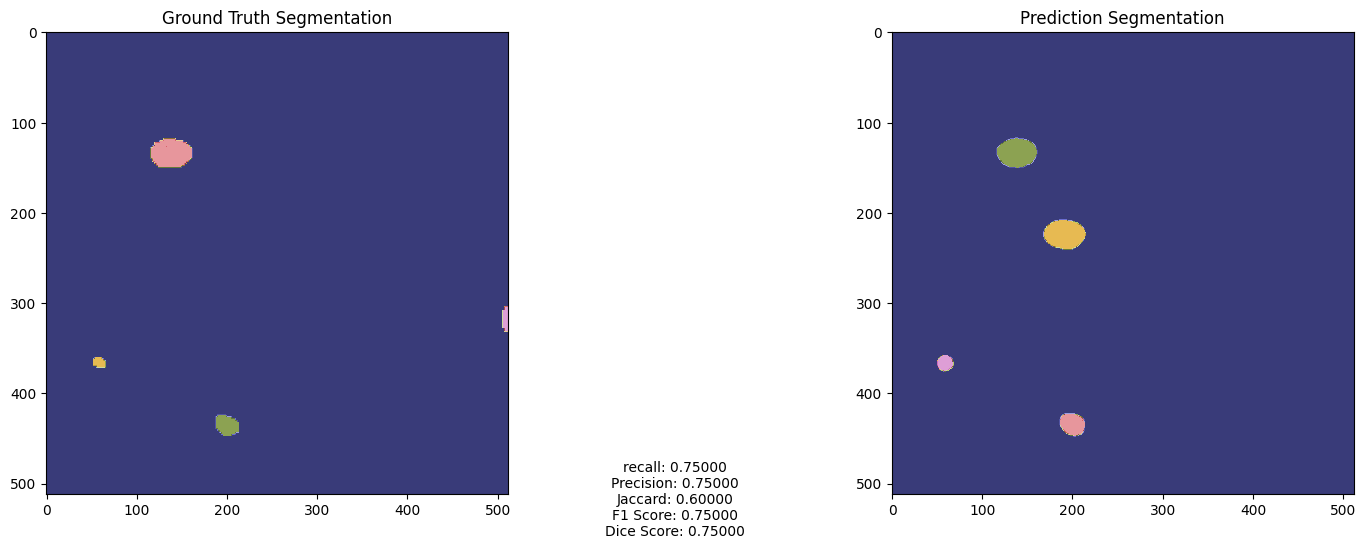

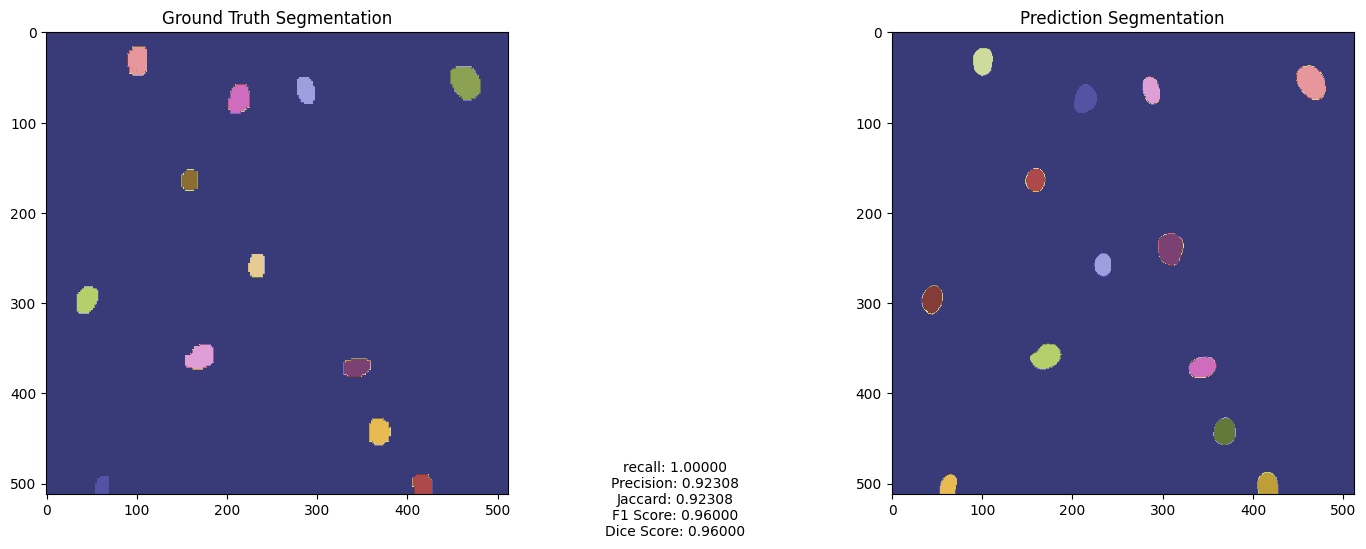

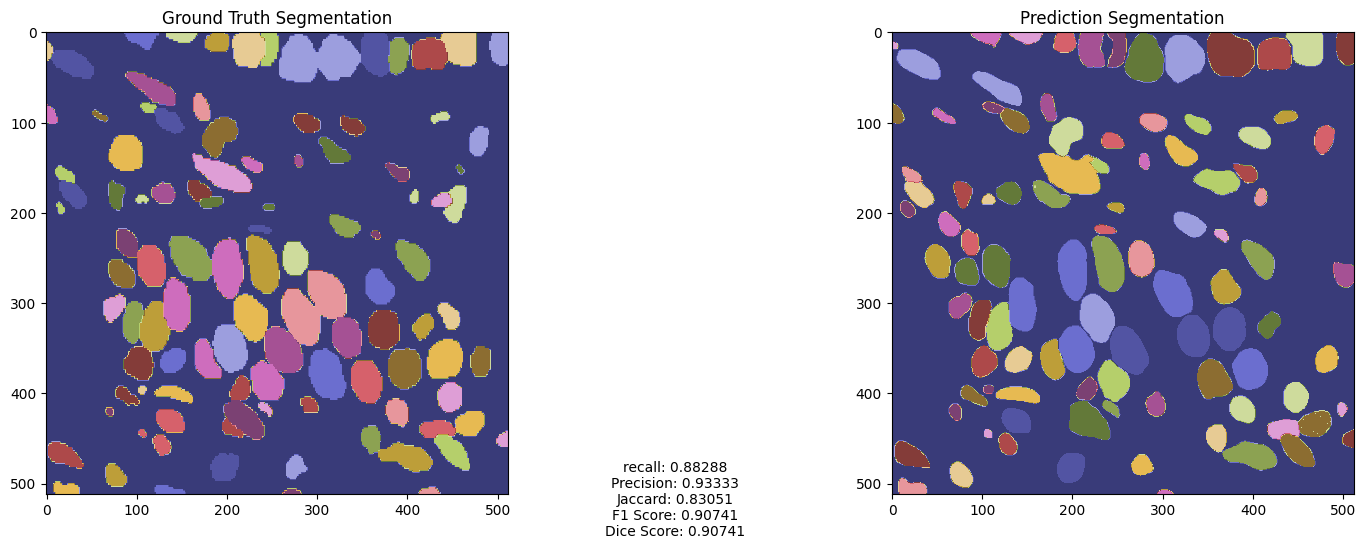

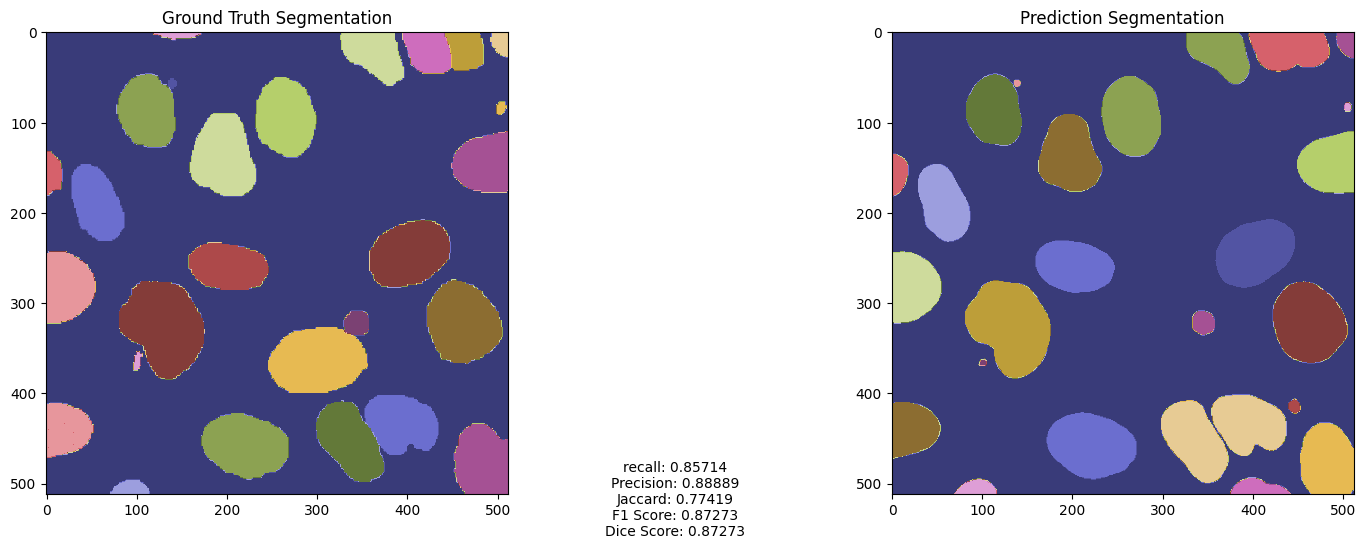

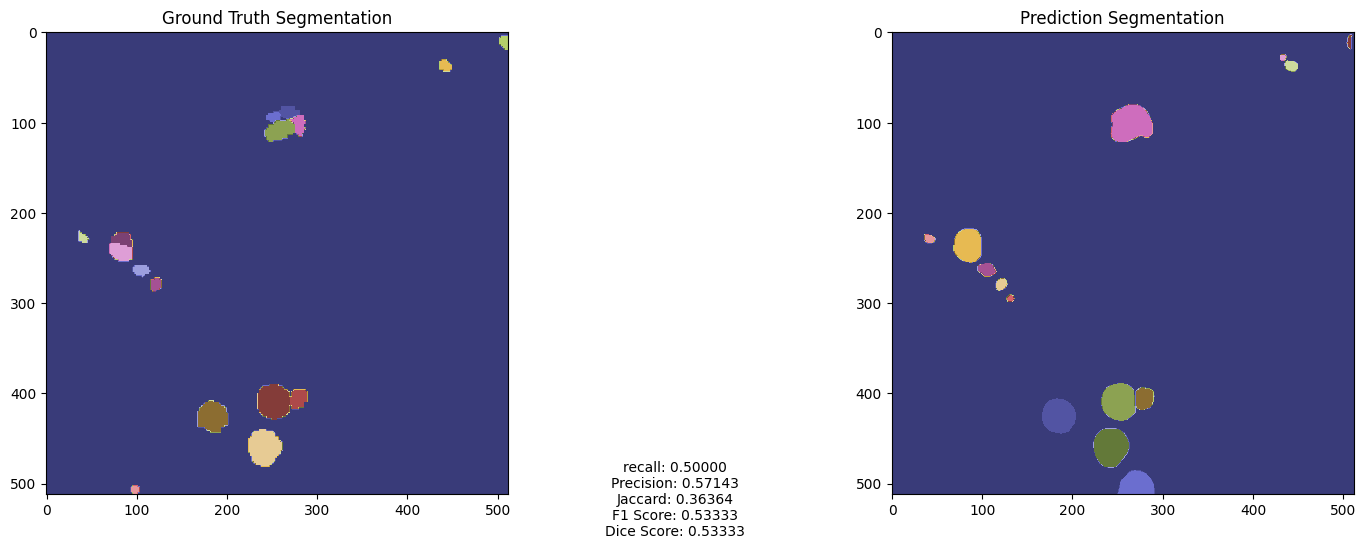

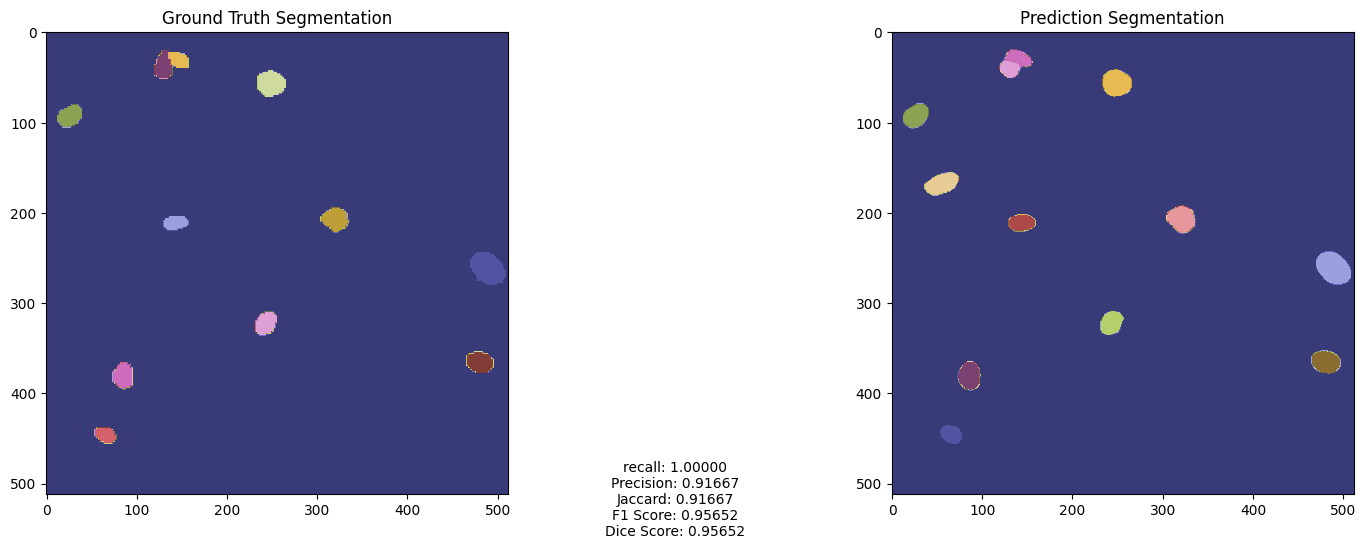

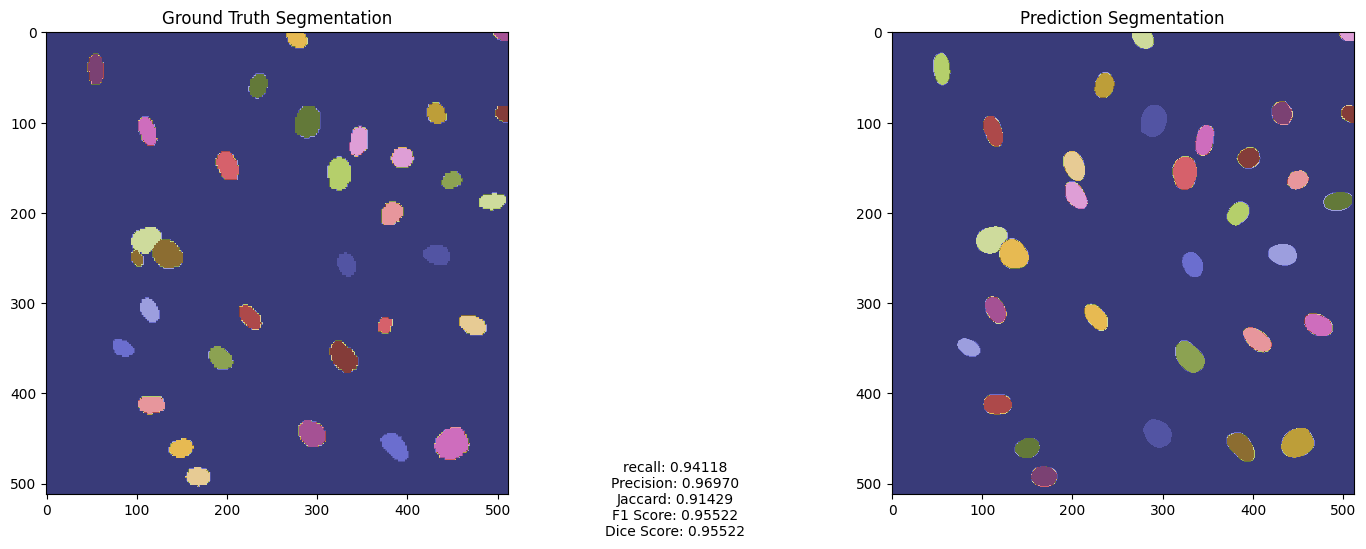

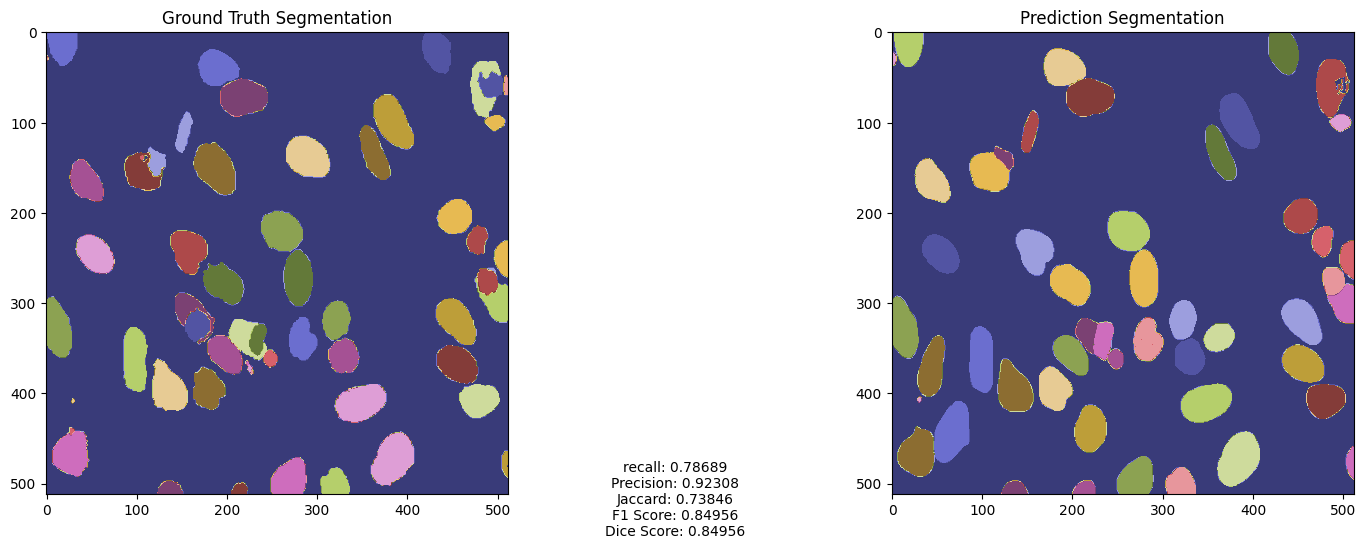

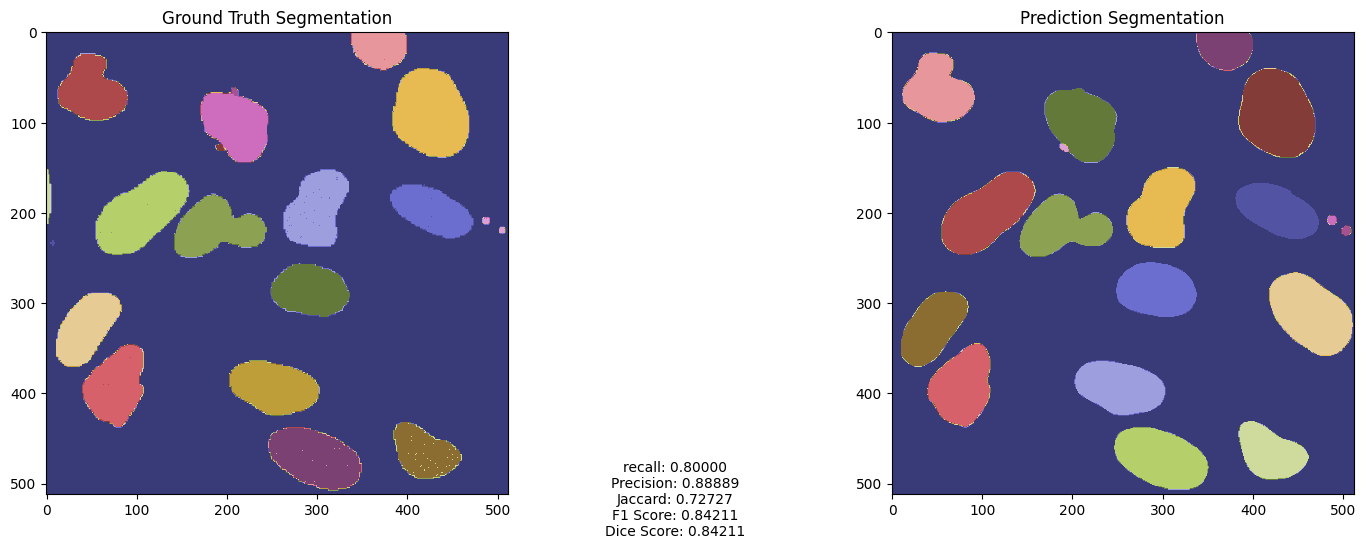

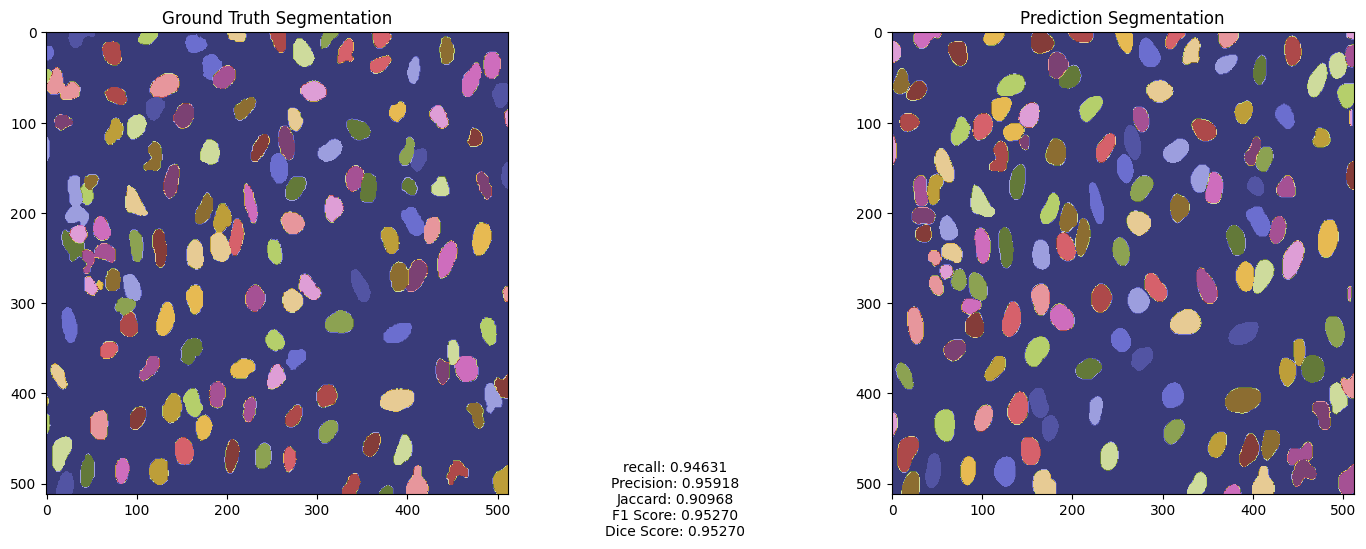

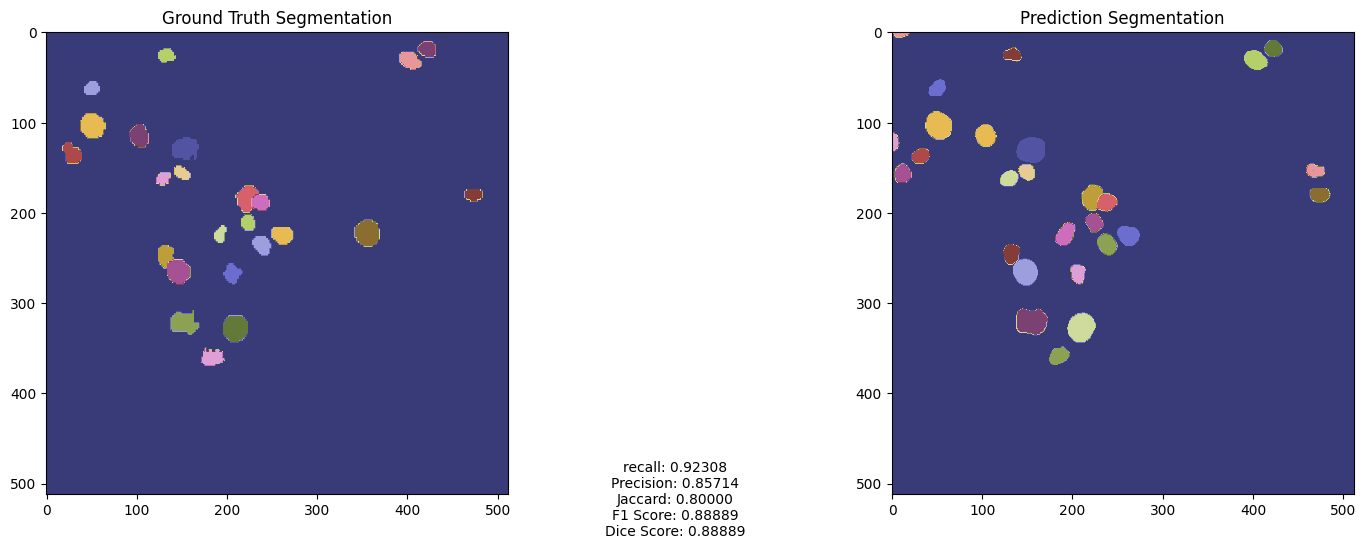

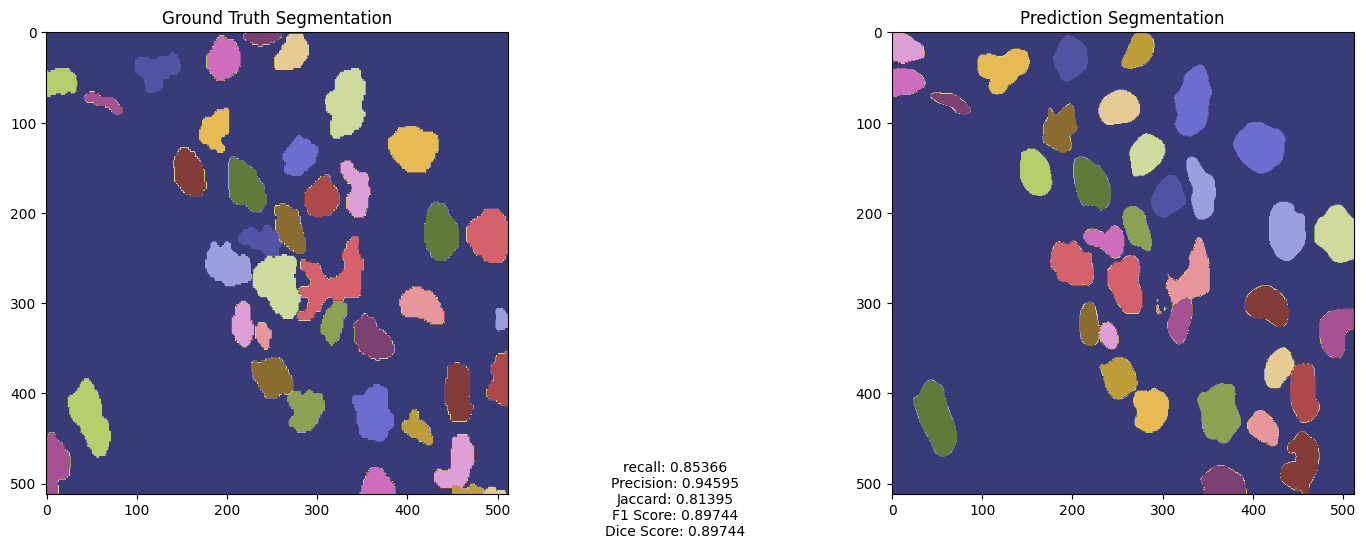

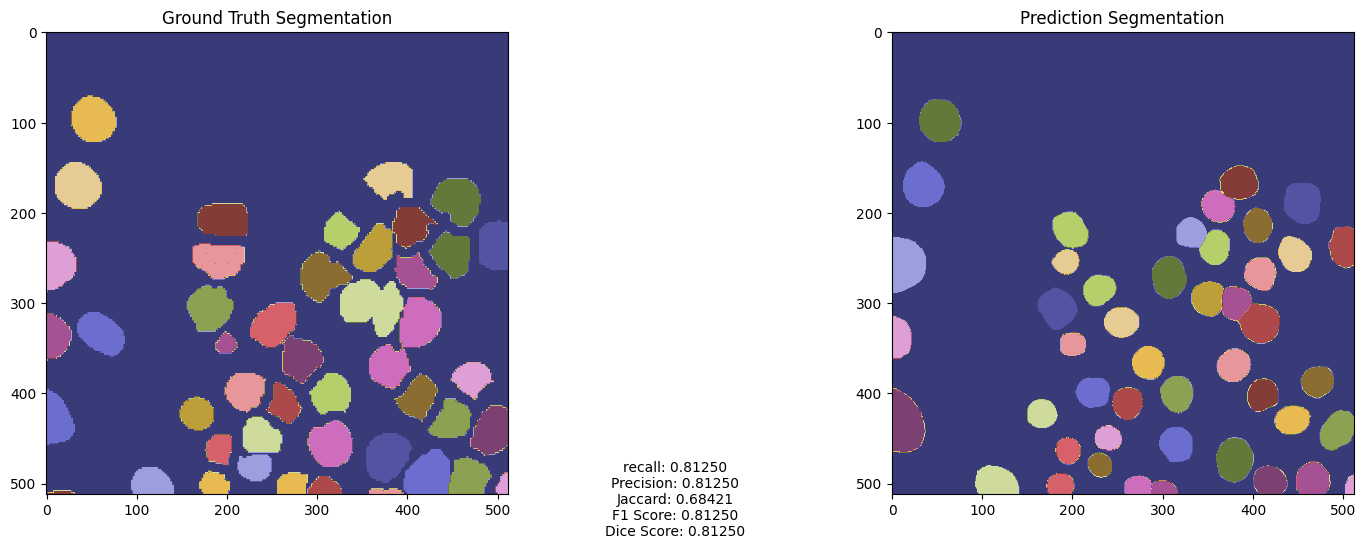

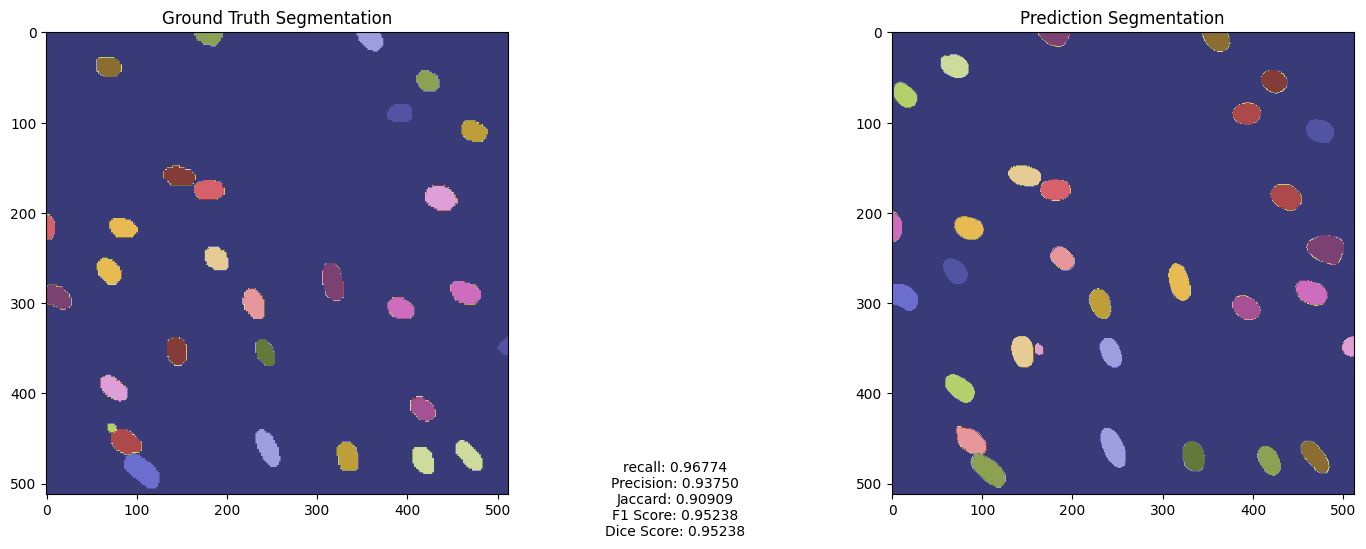

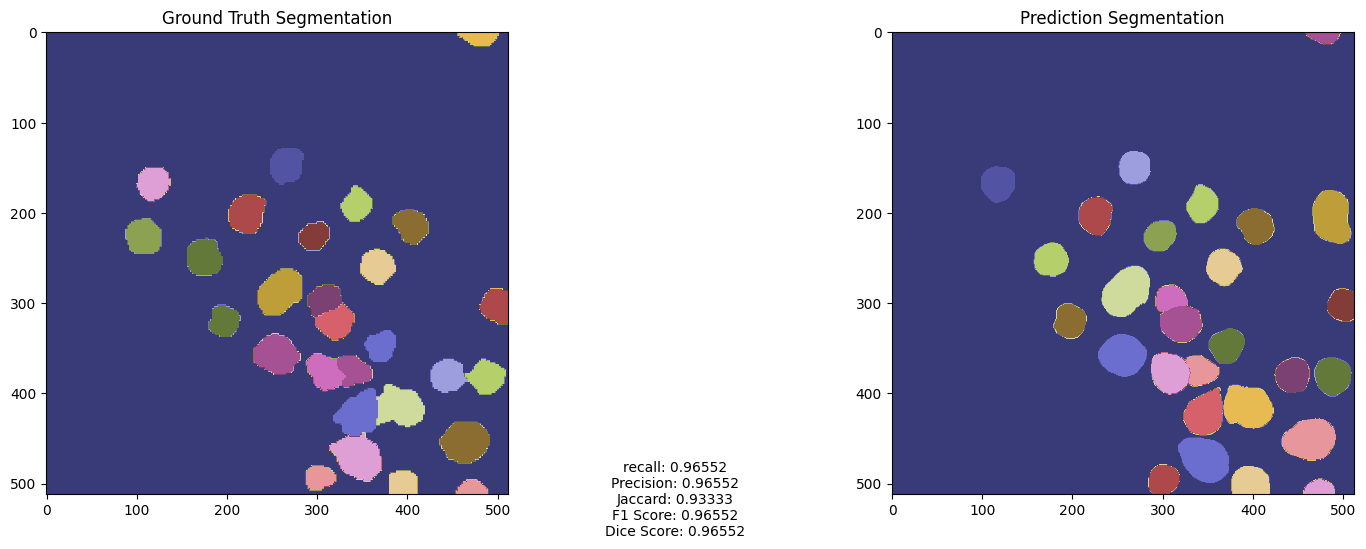

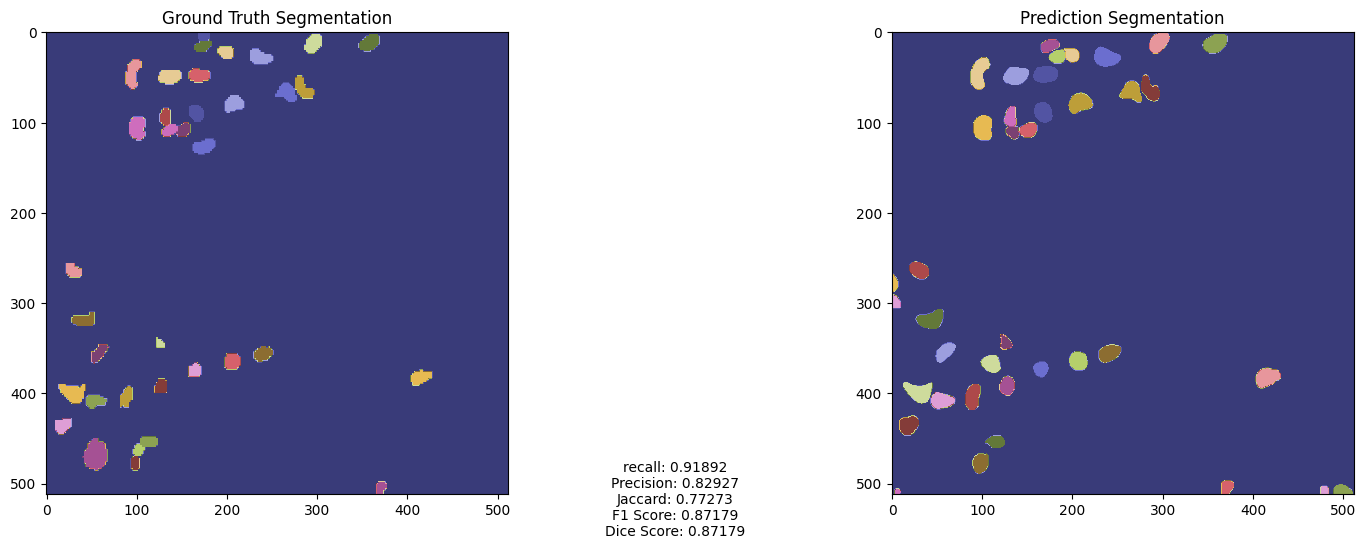

In [18]:
# Calculate the Jaccard, precision, recall, F1 score and dice score

# Initialize lists to store metrics for each image
jaccards = []
precisions = []
recalls = []
f1_scores = []
dices = []
ious = []
ajis = []  
segs = [] 

for i, (orig_img, true_img, pred_img) in enumerate(zip(X_test, y_true, CenterSAM_predict_result)):
    print(f"Processing image {i + 1}/{len(y_true)}...")
    visualize_comparison(orig_img, true_img.squeeze(), pred_img.squeeze(), i)
    
    # Compute metrics for the current image
    jaccard, precision, recall, f1, dice, _, image_ious = compute_instance_metrics(true_img.squeeze(), pred_img.squeeze())
    aji = compute_aji(true_img.squeeze(), pred_img.squeeze())
    seg = compute_seg(true_img.squeeze(), pred_img.squeeze())
    
    
    
    # Append the metrics to the lists
    jaccards.append(jaccard)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    dices.append(dice)
    ious.extend(image_ious)
    ajis.append(aji)
    segs.append(seg)
    
    print('AJI: ' + str(aji))
    print('SEG: ' + str(seg))
    print('recall: ' + str(recall))
    print('precision: ' + str(precision))
    print('jaccard: ' + str(jaccard))
    print('f1: ' + str(f1))
    print('dice: ' + str(dice))

# Compute the average of the metrics over all images


avg_recall = np.mean(recalls)
avg_precision = np.mean(precisions)
avg_jaccard = np.mean(jaccards)
avg_f1 = np.mean(f1_scores)
avg_dice = np.mean(dices)
avg_iou = np.mean(ious)
avg_aji = np.mean(ajis)
avg_seg = np.mean(segs)

print("\nOverall Evaluation Metrics:")
print(f"Average Recall: {avg_recall:.5f}")
print(f"Average Precision: {avg_precision:.5f}")
print(f"Average Jaccard: {avg_jaccard:.5f}")
print(f"Average F1 Score: {avg_f1:.5f}")
print(f"Average Dice Score: {avg_dice:.5f}")
print(f"Average IoU: {avg_iou:.5f}")
print(f"Average AJI: {avg_aji:.5f}")
print(f"Average SEG: {avg_seg:.5f}")